<a href="https://colab.research.google.com/github/HerlanAssis/am-enem-2019/blob/main/am_enem_2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Programa de Pós Graduação em Ciência da Computação - PPgCC
===
Disciplina: Aprendizagem de Máquina  

Docentes:
> Prof. Dr. Isaac De Lima Oliveira Filho  
> Prof. Dr. Marcelino Pereira dos Santos Silva

Discentes:
> Alfredo Felipe Lopes Neto  
> José Ricardo Soriano  
> Herlan Assis Pereira da Silva


Trabalho Final – Aprendizagem de Máquina – Unidade III
===

## Enem 2019
Este trabalho tem o objetivo de fazer uma análise entre alunos de escola privada e escola pública do Enem 2019 relacionando as notas com os dados socioeconômicos utilizando técnias de aprendizagem de máquina.

Possíveis questôes a serem respondidas
--------------------------------------
1. Existe diferença entre os egressos de escola pública e privada?
2. Qual a provável nota do candidato do enem com base nos dados socioeconômicos?

# 1 Escolher a base de dados a ser utilizada;

In [4]:
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install xgboost

In [5]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

### ENEM 2019

In [6]:
data_path_enem = "./files/DADOS/MICRODADOS_ENEM_2019.csv"

# Info on how to get your api key (kaggle.json) here: https://github.com/Kaggle/kaggle-api#api-credentials
from google.colab import files
files.upload()

!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d saraivaufc/enem-2019
!ls

import zipfile
zip_ref = zipfile.ZipFile('enem-2019.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()

Saving kaggle.json to kaggle.json
 98% 665M/679M [00:06<00:00, 102MB/s] 
100% 679M/679M [00:06<00:00, 117MB/s]
enem-2019.zip  kaggle.json  sample_data


In [7]:
enem_original_df = pd.read_csv(
    data_path_enem,
    sep=';',
    encoding = "ISO-8859-1",
    iterator=True,
    chunksize=1000,
#     nrows = 1_000_000 # utilizar somente para fins de dev
)

enem_original_df = pd.concat([chunk[chunk['SG_UF_RESIDENCIA'] == 'RN'] for chunk in enem_original_df], ignore_index=True)

In [8]:
enem_original_df.shape

(119179, 136)

### Estudo da Base

- Análise do genêro sexual
- Análise da idade
- Análise da cor/raça
- Análise do tipo de escola
- Análise da situação de conclusão do EM
- Análise da presença na realização das provas
- Gráfico das Notas das provas de Ciências da Natureza
- Gráfico das Notas das provas de Ciências Humanas
- Gráfico das Notas das provas de Linguagens e Códigos
- Gráfico das Notas das provas de Matemática
- Gráfico das Notas das provas de redação
- Análise dos dados sicioeconômicos

#### Análise do genêro sexual

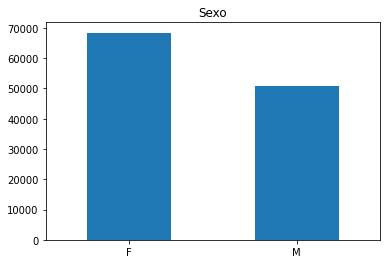

In [9]:
'''
M	Masculino
F	Feminino 
'''

enem_original_df['TP_SEXO'].value_counts(sort=False).plot(title='Sexo', kind='bar', rot=0)

#### Análise da idade

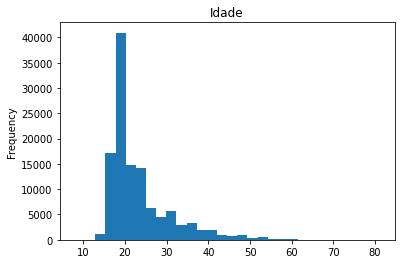

In [10]:
enem_original_df['NU_IDADE'].plot.hist(title='Idade', bins=30)

#### Análise da cor/raça

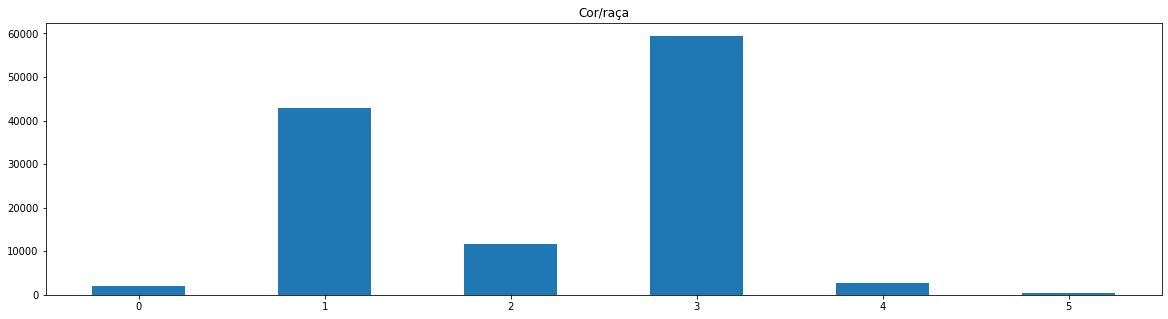

In [11]:
'''
0	Não declarado
1	Branca
2	Preta
3	Parda
4	Amarela
5	Indígena 
'''
enem_original_df['TP_COR_RACA'].value_counts(sort=False).plot(title='Cor/raça', kind='bar', figsize=(20,5), rot=0)

#### Análise do tipo de escola

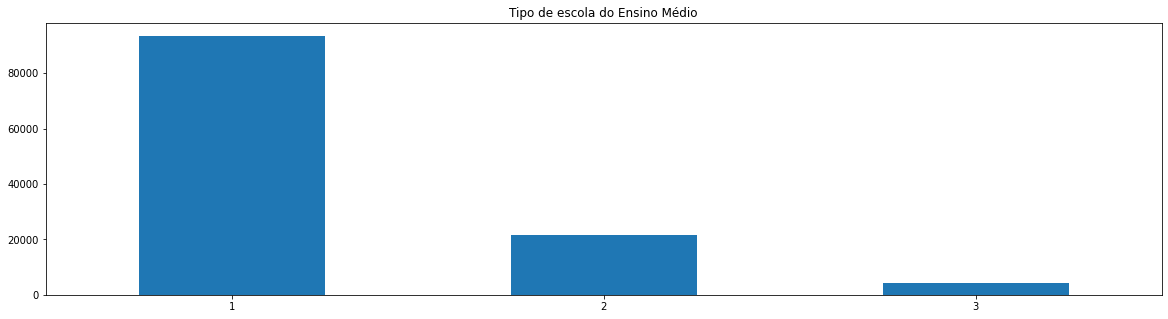

In [12]:
'''
1	Não Respondeu
2	Pública
3	Privada
4	Exterior
'''

enem_original_df['TP_ESCOLA'].value_counts(sort=False).plot(title='Tipo de escola do Ensino Médio',kind='bar', figsize=(20,5), rot=0)

#### Análise do ano de conclusão do EM

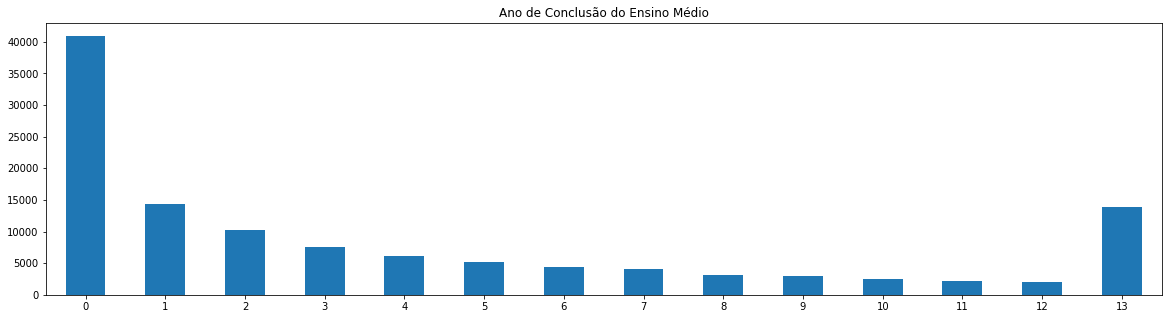

In [13]:
'''
0	Não informado
1	2018
2	2017
3	2016
4	2015
5	2014
6	2013
7	2012
8	2011
9	2010
10	2009
11	2008
12	2007
13	Antes de 2007
'''

enem_original_df['TP_ANO_CONCLUIU'].value_counts(sort=False).plot(title='Ano de Conclusão do Ensino Médio', kind='bar', figsize=(20,5), rot=0)

#### Análise da presença


In [14]:
## funções auxiliares

def build_table(df, index, colunms):
    df2 = df[index.keys()]

    pieces = []
    for col in df2.columns:
        tmp_series = df2[col].value_counts()
        tmp_series.name = col
        pieces.append(tmp_series)
    df_value_counts = pd.concat(pieces, axis=1)

    df_t = df_value_counts.T
    df_t.rename(columns=colunms, 
                index=index, inplace=True)

    return df_t


def annotate(ax, labels=None):
    if labels: 
        ax.set_xticklabels(labels)
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x(), p.get_height()))
    
    return ax

In [15]:
index = {
    'TP_PRESENCA_CN': 'Presença na prova objetiva de Ciências da Natureza',
    'TP_PRESENCA_CH': 'Presença na prova objetiva de Ciências Humanas',
    'TP_PRESENCA_LC': 'Presença na prova objetiva de Linguagens e Códigos',
    'TP_PRESENCA_MT': 'Presença na prova objetiva de Matemática',
    'TP_STATUS_REDACAO': 'Situação da redação do participante',
}

In [16]:
index = {
    'TP_STATUS_REDACAO': 'Situação da redação do participante',
}

build_table(enem_original_df, index, {1: 'Sem problemas', 2: 'Anulada', 3: 'Cópia Texto Motivador', 4: 'Em Branco', 
                                      6: 'Fuga ao tema', 7: 'Não atendimento ao tipo textual', 8: 'Texto insuficiente',
                                      9: 'Parte desconectada'})

,Sem problemas,Em Branco,Fuga ao tema,Cópia Texto Motivador,Anulada,Texto insuficiente,Parte desconectada,Não atendimento ao tipo textual
Situação da redação do participante,91149,1369,952,509,211,181,129,64


#### Gráfico das Notas das provas de Ciências da Natureza

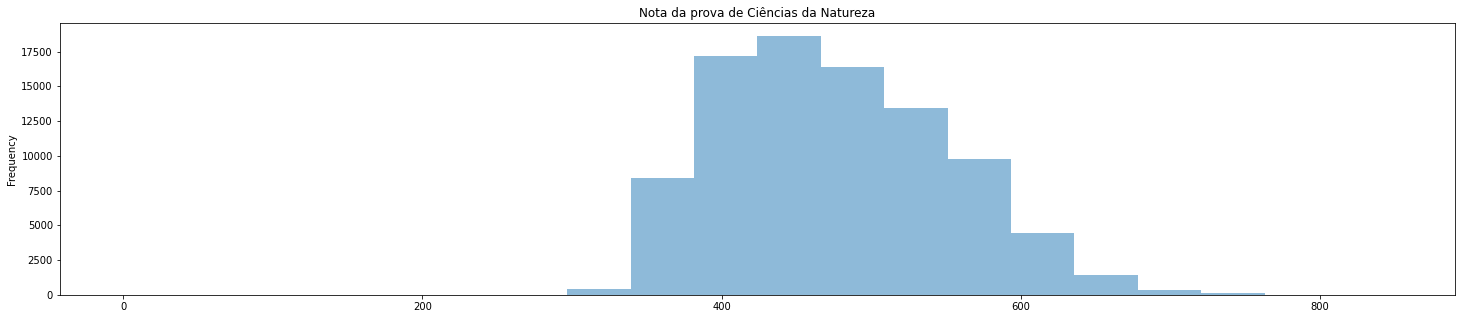

In [17]:
enem_original_df['NU_NOTA_CN'].plot.hist(title='Nota da prova de Ciências da Natureza',bins=20, alpha=0.5, figsize=(25,5))

#### Notas das provas de Ciências Humanas

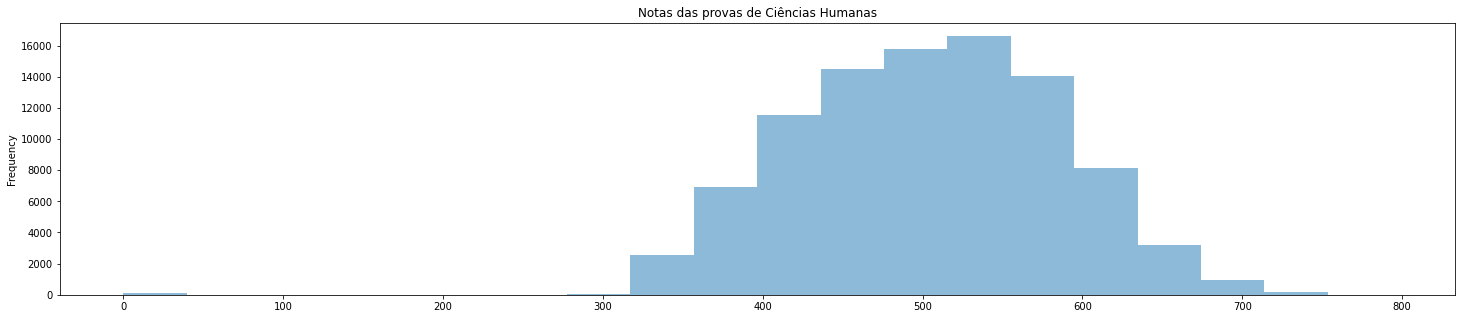

In [18]:
enem_original_df['NU_NOTA_CH'].plot.hist(title='Notas das provas de Ciências Humanas',bins=20, alpha=0.5, figsize=(25,5))

#### Notas das provas de Linguagens e Códigos

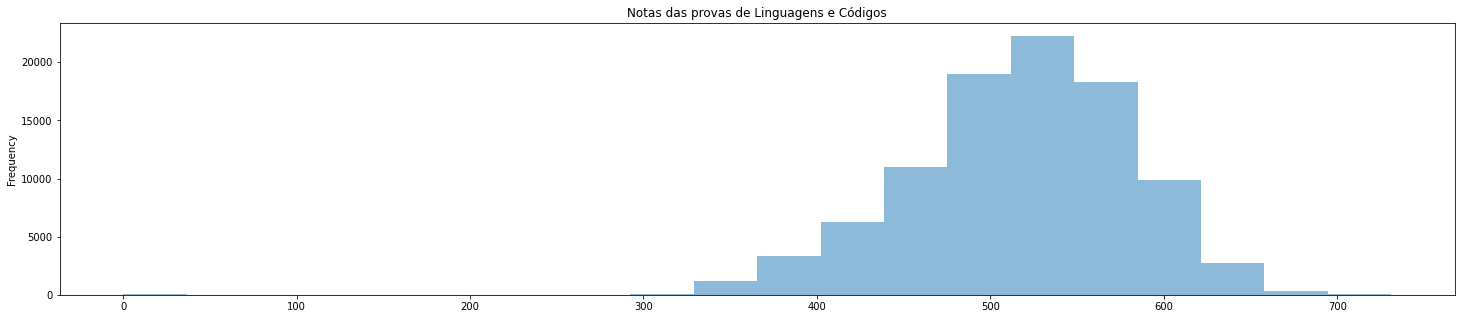

In [19]:
enem_original_df['NU_NOTA_LC'].plot.hist(title='Notas das provas de Linguagens e Códigos',bins=20, alpha=0.5, figsize=(25,5))

#### Notas das provas de Matemática

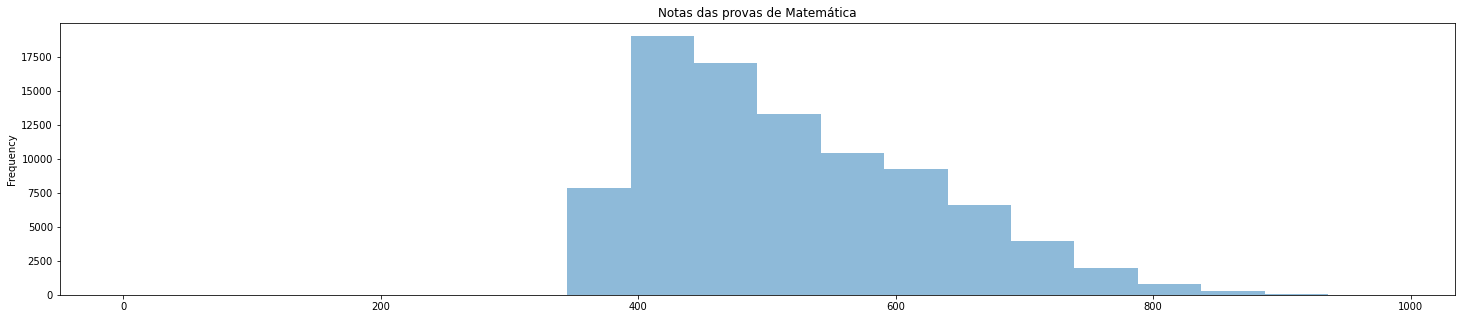

In [20]:
enem_original_df['NU_NOTA_MT'].plot.hist(title='Notas das provas de Matemática',bins=20, alpha=0.5, figsize=(25,5))

#### Notas das provas de redação

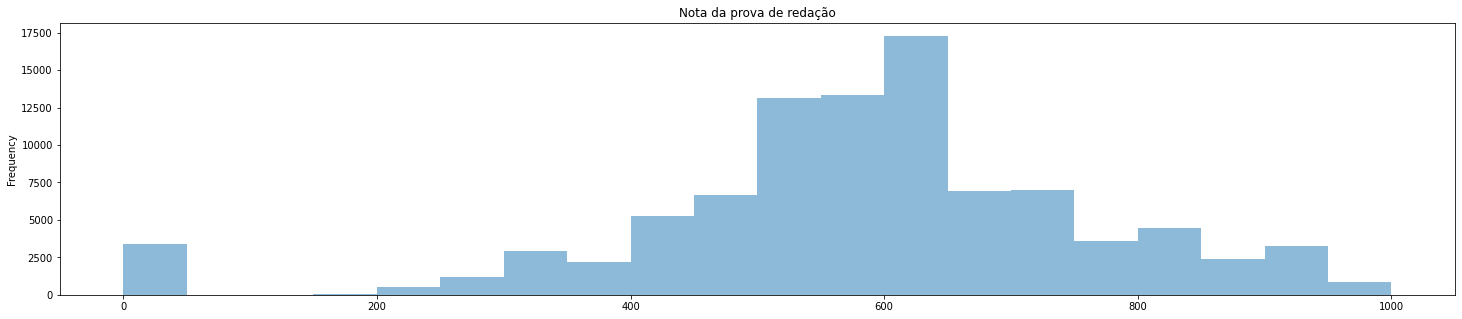

In [21]:
enem_original_df['NU_NOTA_REDACAO'].plot.hist(title='Nota da prova de redação',bins=20, alpha=0.5, figsize=(25,5))

#### Diferenças entre escola Pública e Privada

##### Notas da redação

In [22]:
enem_df = enem_original_df.copy()
enem_df = enem_df.loc[enem_df['TP_ESCOLA'].isin([2, 3])]

'''
Filtrmos dos registros de alunos de escolas públicas e privadas (valores 2 e 3 no campo TP_ESCOLA)
'''
enem_df['NOTA_MEDIA'] = (enem_df['NU_NOTA_CN'] + enem_df['NU_NOTA_CH'] + enem_df['NU_NOTA_LC'] + enem_df['NU_NOTA_MT']) / 4

enem_df = enem_df.loc[enem_df['TP_ESCOLA'].isin([2, 3])]
enem_df.loc[enem_df['TP_ESCOLA']==2, 'TP_ESCOLA'] = 'Pública'
enem_df.loc[enem_df['TP_ESCOLA']==3, 'TP_ESCOLA'] = 'Privada'
    
enem_df[['TP_ESCOLA', 'NU_NOTA_REDACAO']].groupby('TP_ESCOLA').describe()

NU_NOTA_REDACAO                          ...                      
                    count        mean         std  ...    50%    75%     max
TP_ESCOLA                                          ...                      
Privada            4007.0  728.125780  168.710880  ...  740.0  860.0  1000.0
Pública           19271.0  567.547091  192.290748  ...  580.0  680.0   980.0

[2 rows x 8 columns]

##### Desvio médio das notas da redação

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


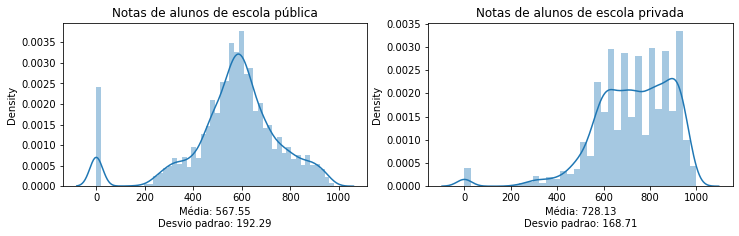

In [23]:
pub = enem_df.loc[enem_df.TP_ESCOLA=='Pública', 'NU_NOTA_REDACAO']
priv = enem_df.loc[enem_df.TP_ESCOLA=='Privada', 'NU_NOTA_REDACAO']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))

p1=sns.distplot(
    pub,
    ax=axes[0],
    axlabel=f'Média: {pub.mean():.2f}\nDesvio padrao: {pub.std():.2f}'
).set_title("Notas de alunos de escola pública")
p2=sns.distplot(
    priv,
    axlabel=f'Média: {priv.mean():.2f}\nDesvio padrao: {priv.std():.2f}'
).set_title("Notas de alunos de escola privada")
plt.show()


#### Média das Provas Objetivas

In [24]:
enem_df[['TP_ESCOLA', 'NOTA_MEDIA']].groupby('TP_ESCOLA').describe()

NOTA_MEDIA                         ...                              
               count        mean        std  ...       50%        75%      max
TP_ESCOLA                                    ...                              
Privada       3964.0  558.734492  71.894775  ...  560.9625  610.09375  798.300
Pública      18590.0  491.208852  63.871119  ...  480.7750  531.60000  760.575

[2 rows x 8 columns]

##### Desvio médio das notas da média das provas objetivas

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


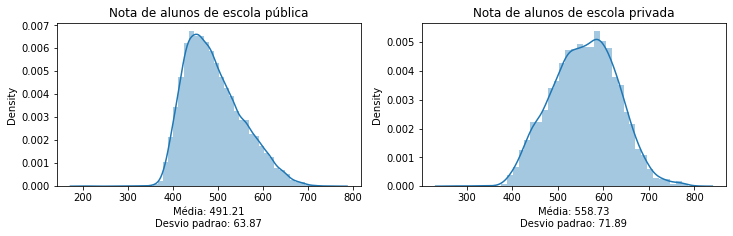

In [25]:
pub = enem_df.loc[enem_df.TP_ESCOLA=='Pública', 'NOTA_MEDIA']
priv = enem_df.loc[enem_df.TP_ESCOLA=='Privada', 'NOTA_MEDIA']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))

p1=sns.distplot(
    pub,
    ax=axes[0],
    axlabel=f'Média: {pub.mean():.2f}\nDesvio padrao: {pub.std():.2f}'
).set_title("Nota de alunos de escola pública")
p2=sns.distplot(
    priv,
    axlabel=f'Média: {priv.mean():.2f}\nDesvio padrao: {priv.std():.2f}'
).set_title("Nota de alunos de escola privada")
plt.show()

#### Dados do questionário socioeconômico [Q001]

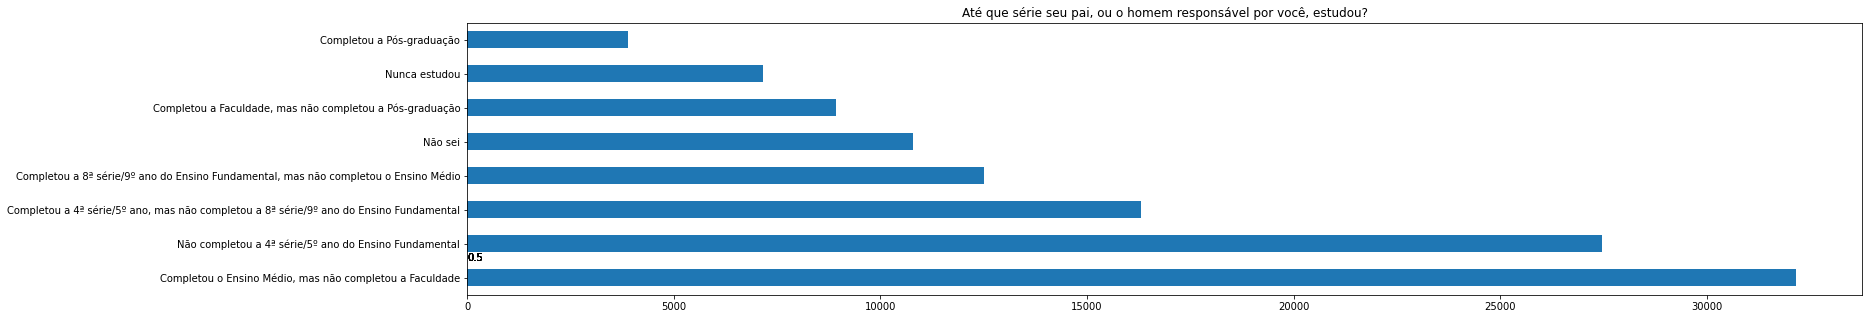

In [26]:
ax = enem_original_df['Q001'].value_counts(sort=True).plot.barh(title='Até que série seu pai, ou o homem responsável por você, estudou?', figsize=(25,5), rot=0)

ax.set_yticklabels([
    'Completou o Ensino Médio, mas não completou a Faculdade',
    'Não completou a 4ª série/5º ano do Ensino Fundamental',
    'Completou a 4ª série/5º ano, mas não completou a 8ª série/9º ano do Ensino Fundamental',
    'Completou a 8ª série/9º ano do Ensino Fundamental, mas não completou o Ensino Médio',
    'Não sei',
    'Completou a Faculdade, mas não completou a Pós-graduação',
    'Nunca estudou',
    'Completou a Pós-graduação'
])

annotate(ax)

#### Dados do questionário socioeconômico [Q002]

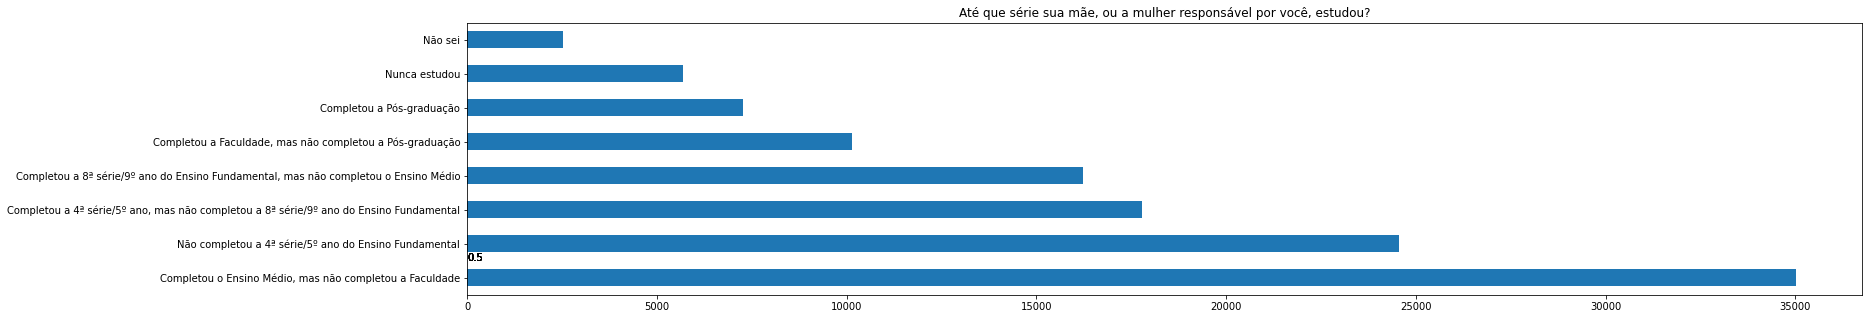

In [27]:
ax = enem_original_df['Q002'].value_counts(sort=True).plot.barh(title='Até que série sua mãe, ou a mulher responsável por você, estudou?', figsize=(25,5), rot=0)

ax.set_yticklabels([
    'Completou o Ensino Médio, mas não completou a Faculdade',
    'Não completou a 4ª série/5º ano do Ensino Fundamental',
    'Completou a 4ª série/5º ano, mas não completou a 8ª série/9º ano do Ensino Fundamental',
    'Completou a 8ª série/9º ano do Ensino Fundamental, mas não completou o Ensino Médio',
    'Completou a Faculdade, mas não completou a Pós-graduação',
    'Completou a Pós-graduação',
    'Nunca estudou',
    'Não sei'
])

annotate(ax)

#### Dados do questionário socioeconômico [Q003]

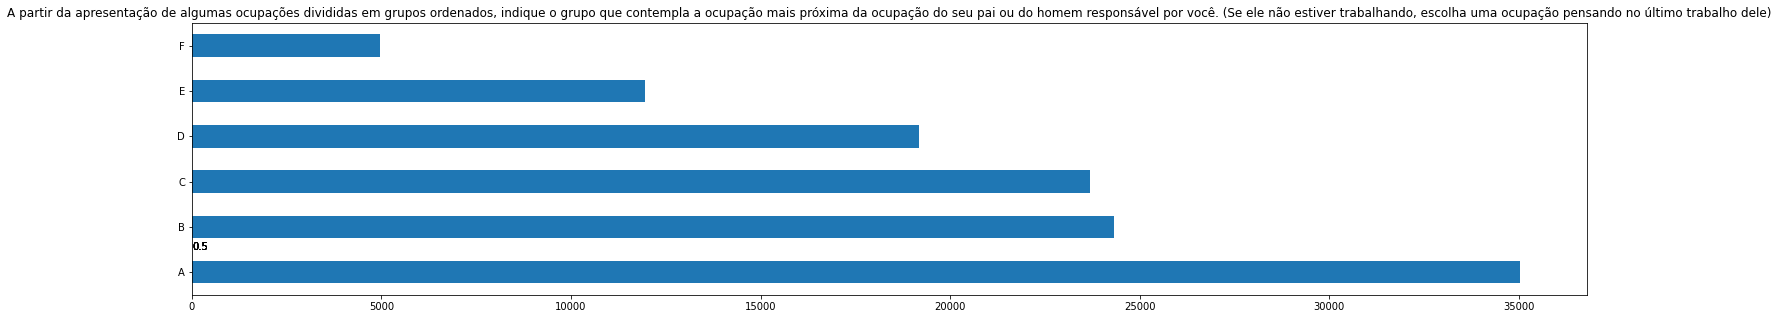

In [28]:
ax = enem_original_df['Q003'].value_counts(sort=True).plot.barh(title='A partir da apresentação de algumas ocupações divididas em grupos ordenados, indique o grupo que contempla a ocupação mais próxima da ocupação do seu pai ou do homem responsável por você. (Se ele não estiver trabalhando, escolha uma ocupação pensando no último trabalho dele)', figsize=(25,5), rot=0)

'''
A	Grupo 1: Lavrador, agricultor sem empregados, bóia fria, criador de animais (gado, porcos, galinhas, ovelhas, cavalos etc.), apicultor, pescador, lenhador, seringueiro, extrativista.
B	Grupo 2: Diarista, empregado doméstico, cuidador de idosos, babá, cozinheiro (em casas particulares), motorista particular, jardineiro, faxineiro de empresas e prédios, vigilante, porteiro, carteiro, office-boy, vendedor, caixa, atendente de loja, auxiliar administrativo, recepcionista, servente de pedreiro, repositor de mercadoria.
C	Grupo 3: Padeiro, cozinheiro industrial ou em restaurantes, sapateiro, costureiro, joalheiro, torneiro mecânico, operador de máquinas, soldador, operário de fábrica, trabalhador da mineração, pedreiro, pintor, eletricista, encanador, motorista, caminhoneiro, taxista.
D	Grupo 4: Professor (de ensino fundamental ou médio, idioma, música, artes etc.), técnico (de enfermagem, contabilidade, eletrônica etc.), policial, militar de baixa patente (soldado, cabo, sargento), corretor de imóveis, supervisor, gerente, mestre de obras, pastor, microempresário (proprietário de empresa com menos de 10 empregados), pequeno comerciante, pequeno proprietário de terras, trabalhador autônomo ou por conta própria.
E	Grupo 5: Médico, engenheiro, dentista, psicólogo, economista, advogado, juiz, promotor, defensor, delegado, tenente, capitão, coronel, professor universitário, diretor em empresas públicas ou privadas, político, proprietário de empresas com mais de 10 empregados.
F	Não sei.
'''

ax.set_yticklabels([
    'A',
    'B',
    'C',
    'D',
    'E',
    'F'
])

annotate(ax)

#### Dados do questionário socioeconômico [Q004]

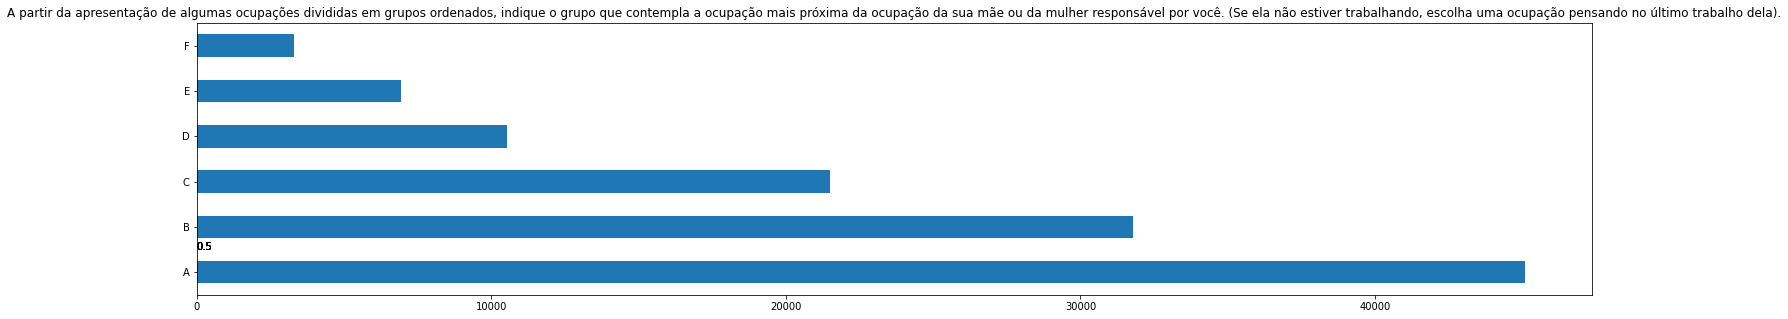

In [29]:
ax = enem_original_df['Q004'].value_counts(sort=True).plot.barh(title='A partir da apresentação de algumas ocupações divididas em grupos ordenados, indique o grupo que contempla a ocupação mais próxima da ocupação da sua mãe ou da mulher responsável por você. (Se ela não estiver trabalhando, escolha uma ocupação pensando no último trabalho dela).', figsize=(25,5), rot=0)

'''
A	Grupo 1: Lavradora, agricultora sem empregados, bóia fria, criadora de animais (gado, porcos, galinhas, ovelhas, cavalos etc.), apicultora, pescadora, lenhadora, seringueira, extrativista.
B	Grupo 2: Diarista, empregada doméstica, cuidadora de idosos, babá, cozinheira (em casas particulares), motorista particular, jardineira, faxineira de empresas e prédios, vigilante, porteira, carteira, office-boy, vendedora, caixa, atendente de loja, auxiliar administrativa, recepcionista, servente de pedreiro, repositora de mercadoria.
C	Grupo 3: Padeira, cozinheira industrial ou em restaurantes, sapateira, costureira, joalheira, torneira mecânica, operadora de máquinas, soldadora, operária de fábrica, trabalhadora da mineração, pedreira, pintora, eletricista, encanadora, motorista, caminhoneira, taxista.
D	Grupo 4: Professora (de ensino fundamental ou médio, idioma, música, artes etc.), técnica (de enfermagem, contabilidade, eletrônica etc.), policial, militar de baixa patente (soldado, cabo, sargento), corretora de imóveis, supervisora, gerente, mestre de obras, pastora, microempresária (proprietária de empresa com menos de 10 empregados), pequena comerciante, pequena proprietária de terras, trabalhadora autônoma ou por conta própria.
E	Grupo 5: Médica, engenheira, dentista, psicóloga, economista, advogada, juíza, promotora, defensora, delegada, tenente, capitã, coronel, professora universitária, diretora em empresas públicas ou privadas, política, proprietária de empresas com mais de 10 empregados.
'''

ax.set_yticklabels([
    'A',
    'B',
    'C',
    'D',
    'E',
    'F'
])

annotate(ax)

#### Dados do questionário socioeconômico [Q005]

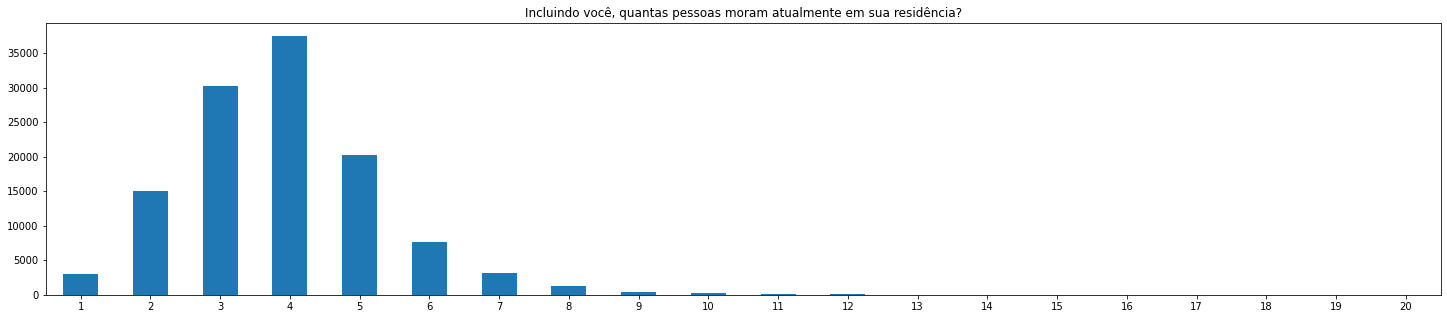

In [30]:
'''
1	1, pois moro sozinho(a).
2	2
3	3
4	4
5	5
6	6
7	7
8	8
9	9
10	10
11	11
12	12
13	13
14	14
15	15
16	16
17	17
18	18
19	19
20	20
'''
enem_original_df['Q005'].value_counts(sort=False).plot(title='Incluindo você, quantas pessoas moram atualmente em sua residência?', kind='bar', figsize=(25,5), rot=0)

#### Dados do questionário socioeconômico [Q006]

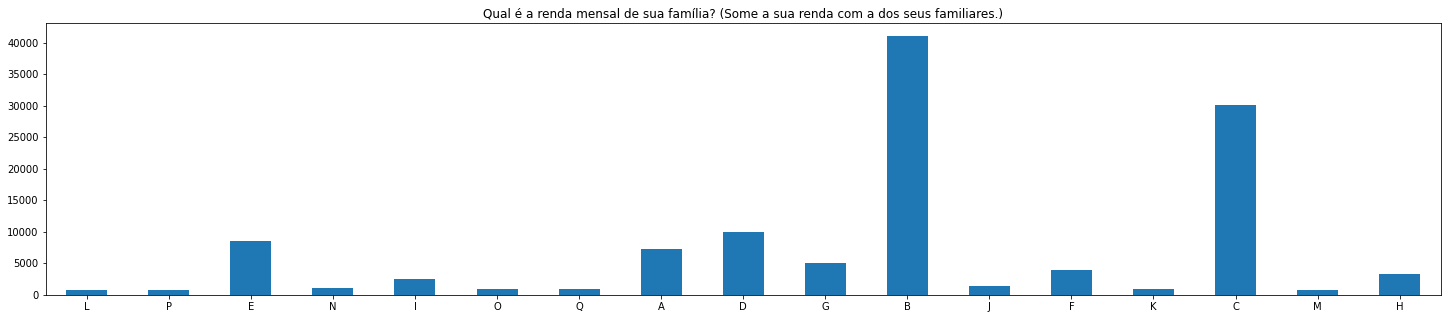

In [31]:
'''
A	Nenhuma renda.
B	Até R$ 998,00.
C	De R$ 998,01 até R$ 1.497,00.
D	De R$ 1.497,01 até R$ 1.996,00.
E	De R$ 1.996,01 até R$ 2.495,00.
F	De R$ 2.495,01 até R$ 2.994,00.
G	De R$ 2.994,01 até R$ 3.992,00.
H	De R$ 3.992,01 até R$ 4.990,00.
I	De R$ 4.990,01 até R$ 5.988,00.
J	De R$ 5.988,01 até R$ 6.986,00.
K	De R$ 6.986,01 até R$ 7.984,00.
L	De R$ 7.984,01 até R$ 8.982,00.
M	De R$ 8.982,01 até R$ 9.980,00.
N	De R$ 9.980,01 até R$ 11.976,00.
O	De R$ 11.976,01 até R$ 14.970,00.
P	De R$ 14.970,01 até R$ 19.960,00.
Q	Mais de R$ 19.960,00.
'''

enem_original_df['Q006'].value_counts(sort=False).plot(title='Qual é a renda mensal de sua família? (Some a sua renda com a dos seus familiares.)', kind='bar', figsize=(25,5), rot=0)

#### Dados do questionário socioeconômico [Q007]

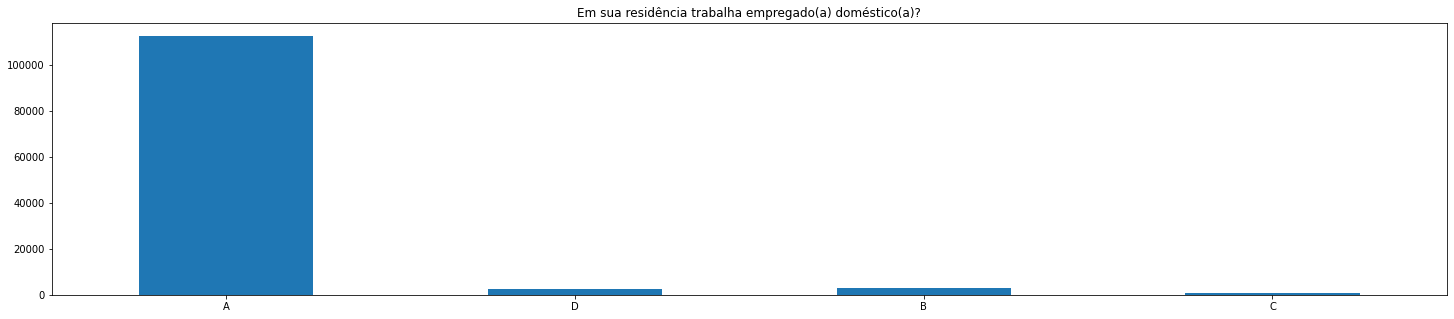

In [32]:
'''
A	Não.
B	Sim, um ou dois dias por semana.
C	Sim, três ou quatro dias por semana.
D	Sim, pelo menos cinco dias por semana.
'''

enem_original_df['Q007'].value_counts(sort=False).plot(title='Em sua residência trabalha empregado(a) doméstico(a)?', kind='bar', figsize=(25,5), rot=0)

#### Dados do questionário socioeconômico [Q008]

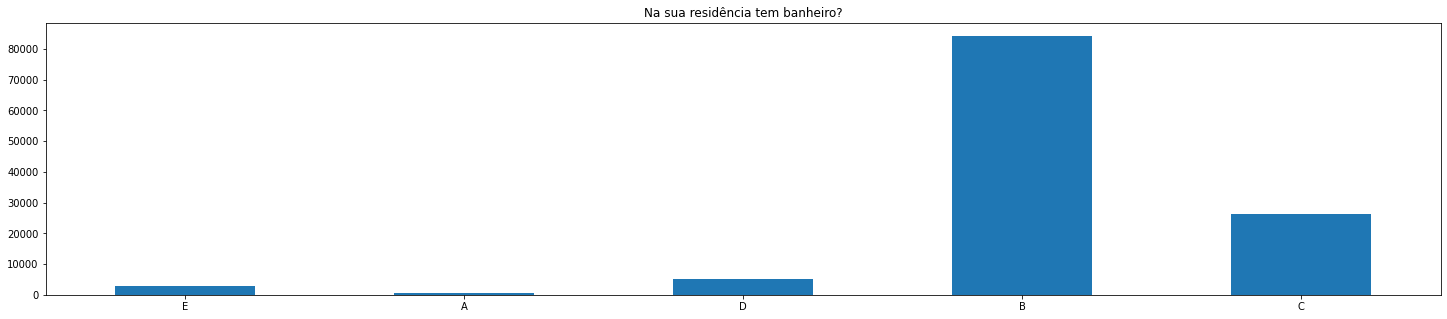

In [33]:
'''
A	Não.
B	Sim, um.
C	Sim, dois.
D	Sim, três.
E	Sim, quatro ou mais.
'''

enem_original_df['Q008'].value_counts(sort=False).plot(title='Na sua residência tem banheiro?', kind='bar', figsize=(25,5), rot=0)

#### Dados do questionário socioeconômico [Q009]

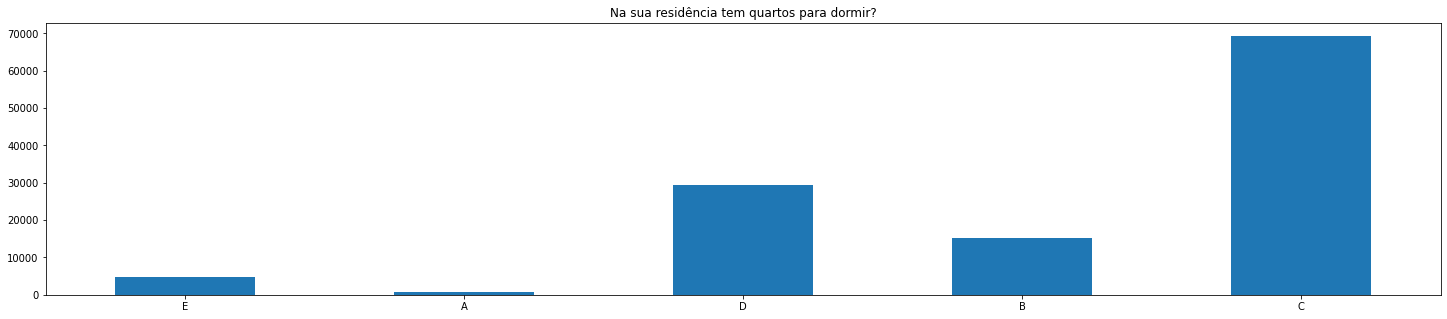

In [34]:
'''
A	Não.
B	Sim, um.
C	Sim, dois.
D	Sim, três.
E	Sim, quatro ou mais.
'''

enem_original_df['Q009'].value_counts(sort=False).plot(title='Na sua residência tem quartos para dormir?', kind='bar', figsize=(25,5), rot=0)

#### Dados do questionário socioeconômico [Q010]

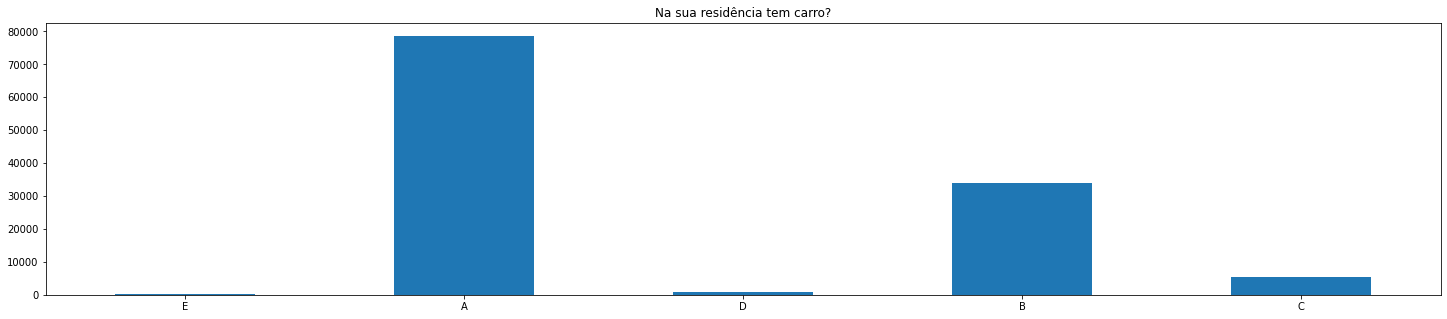

In [35]:
'''
A	Não.
B	Sim, um.
C	Sim, dois.
D	Sim, três.
E	Sim, quatro ou mais.
'''

enem_original_df['Q010'].value_counts(sort=False).plot(title='Na sua residência tem carro?', kind='bar', figsize=(25,5), rot=0)

#### Dados do questionário socioeconômico [Q011]

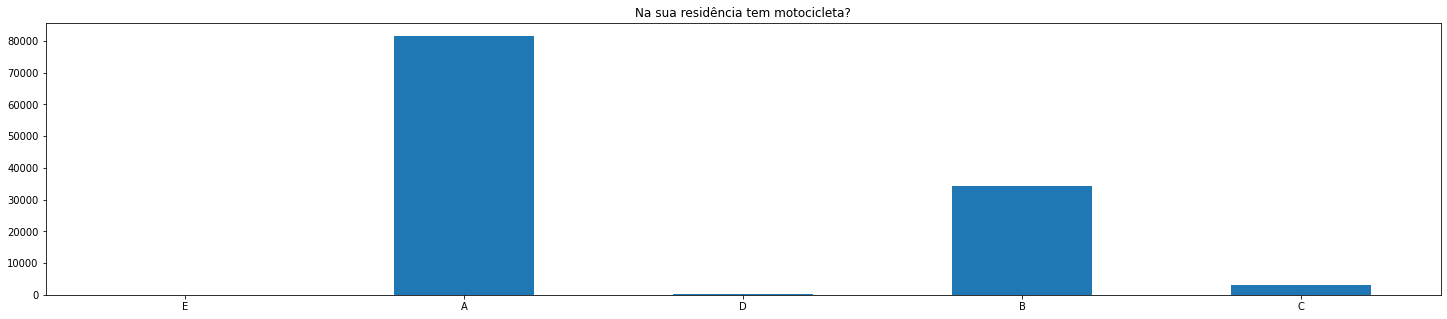

In [36]:
'''
A	Não.
B	Sim, uma.
C	Sim, duas.
D	Sim, três.
E	Sim, quatro ou mais.
'''

enem_original_df['Q011'].value_counts(sort=False).plot(title='Na sua residência tem motocicleta?', kind='bar', figsize=(25,5), rot=0)

#### Dados do questionário socioeconômico [Q012]

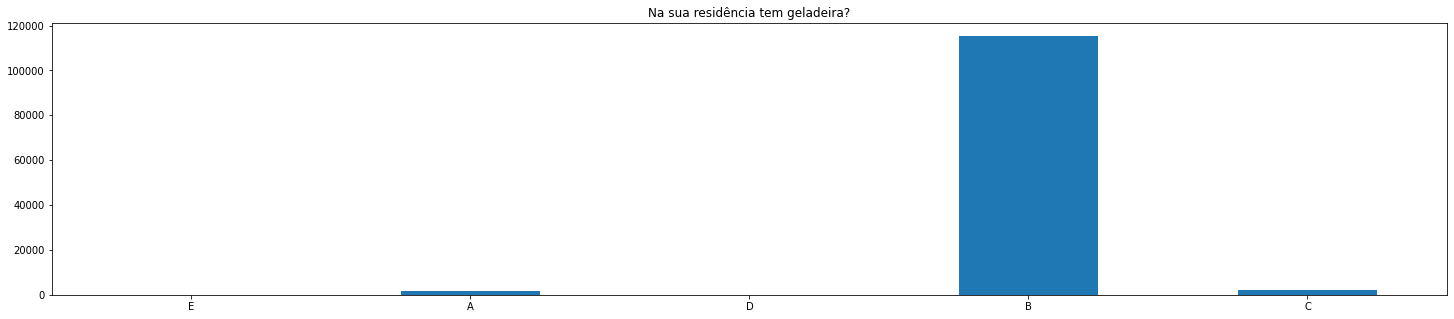

In [37]:
'''
A	Não.
B	Sim, uma.
C	Sim, duas.
D	Sim, três.
E	Sim, quatro ou mais.
'''

enem_original_df['Q012'].value_counts(sort=False).plot(title='Na sua residência tem geladeira?', kind='bar', figsize=(25,5), rot=0)

#### Dados do questionário socioeconômico [Q013]

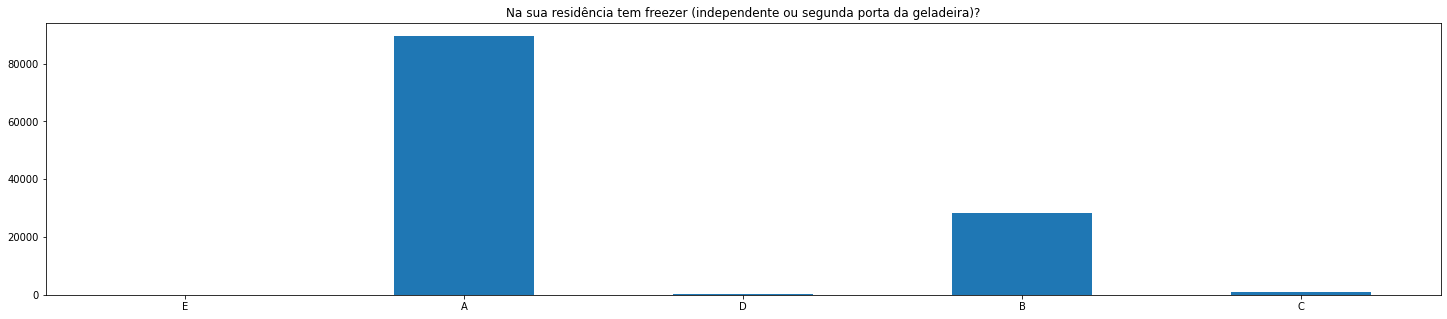

In [38]:
'''
A	Não.
B	Sim, uma.
C	Sim, duas.
D	Sim, três.
E	Sim, quatro ou mais.
'''

enem_original_df['Q013'].value_counts(sort=False).plot(title='Na sua residência tem freezer (independente ou segunda porta da geladeira)?', kind='bar', figsize=(25,5), rot=0)

#### Dados do questionário socioeconômico [Q014]

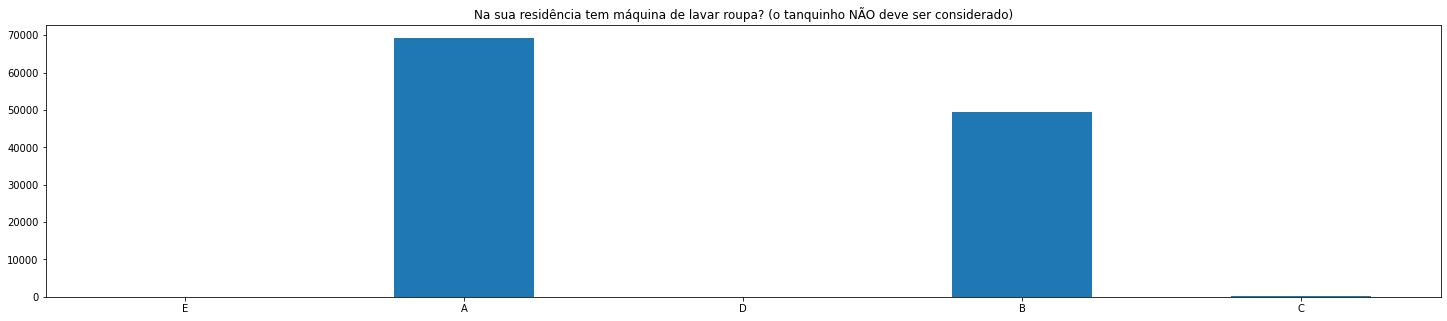

In [39]:
'''
A	Não.
B	Sim, uma.
C	Sim, duas.
D	Sim, três.
E	Sim, quatro ou mais.
'''

enem_original_df['Q014'].value_counts(sort=False).plot(title='Na sua residência tem máquina de lavar roupa? (o tanquinho NÃO deve ser considerado)', kind='bar', figsize=(25,5), rot=0)

#### Dados do questionário socioeconômico [Q015]

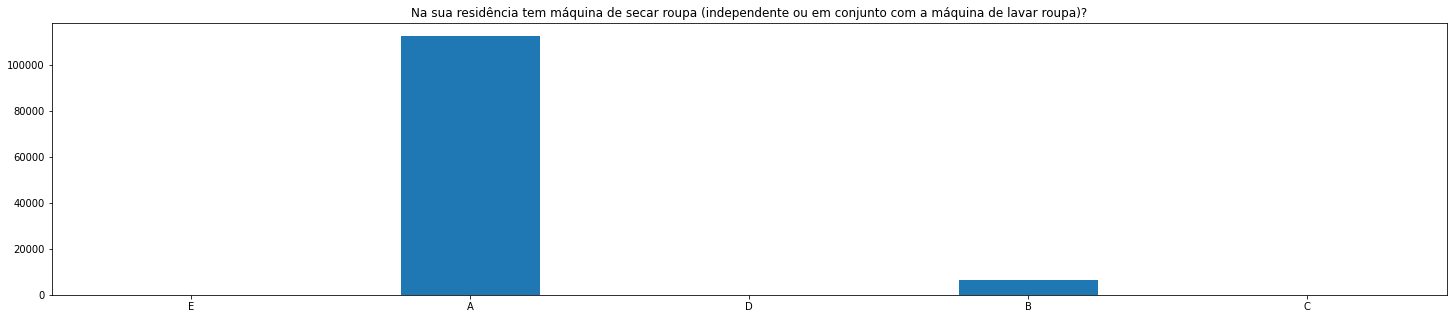

In [40]:
'''
A	Não.
B	Sim, uma.
C	Sim, duas.
D	Sim, três.
E	Sim, quatro ou mais.
'''

enem_original_df['Q015'].value_counts(sort=False).plot(title='Na sua residência tem máquina de secar roupa (independente ou em conjunto com a máquina de lavar roupa)?', kind='bar', figsize=(25,5), rot=0)

#### Dados do questionário socioeconômico [Q016]

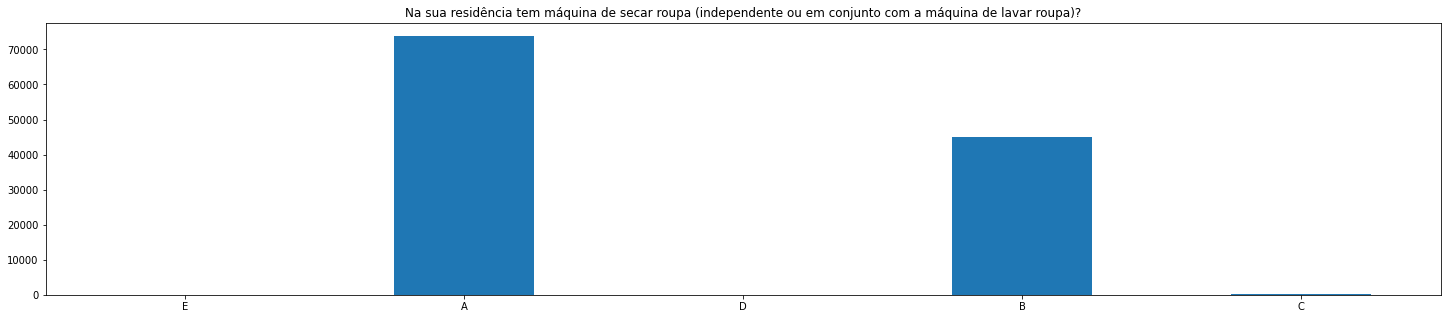

In [41]:
'''
A	Não.
B	Sim, um.
C	Sim, dois.
D	Sim, três.
E	Sim, quatro ou mais.
'''

enem_original_df['Q016'].value_counts(sort=False).plot(title='Na sua residência tem máquina de secar roupa (independente ou em conjunto com a máquina de lavar roupa)?', kind='bar', figsize=(25,5), rot=0)

#### Dados do questionário socioeconômico [Q017]

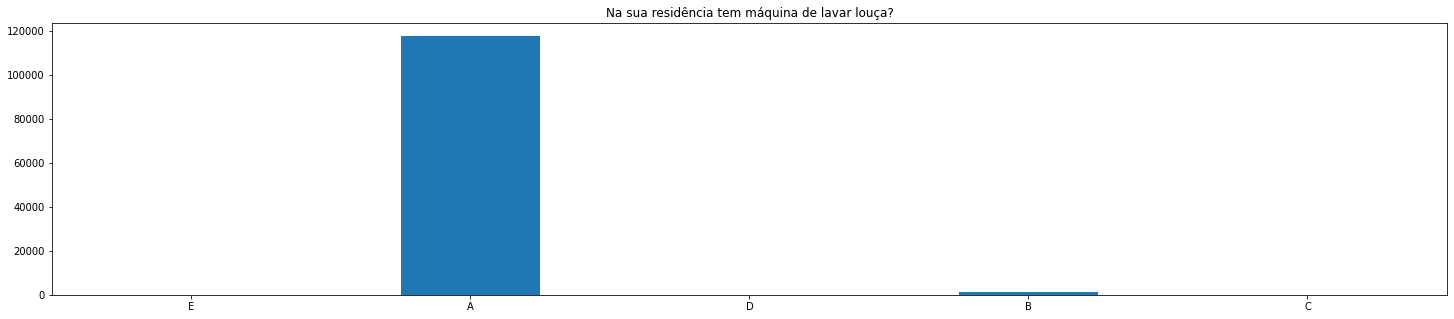

In [42]:
'''
A	Não.
B	Sim, uma.
C	Sim, duas.
D	Sim, três.
E	Sim, quatro ou mais.
'''

enem_original_df['Q017'].value_counts(sort=False).plot(title='Na sua residência tem máquina de lavar louça?', kind='bar', figsize=(25,5), rot=0)

#### Dados do questionário socioeconômico [Q018]

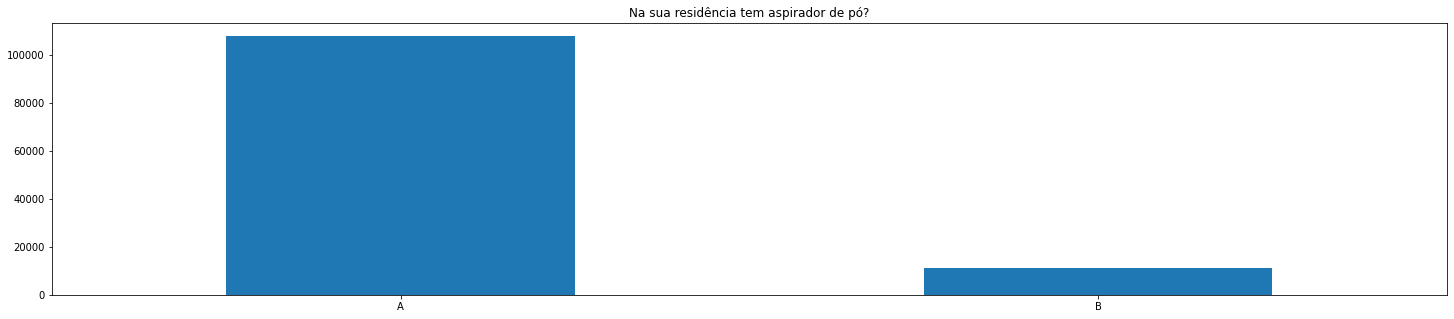

In [43]:
'''
A	Não.
B	Sim.
'''

enem_original_df['Q018'].value_counts(sort=False).plot(title='Na sua residência tem aspirador de pó?', kind='bar', figsize=(25,5), rot=0)

#### Dados do questionário socioeconômico [Q019]

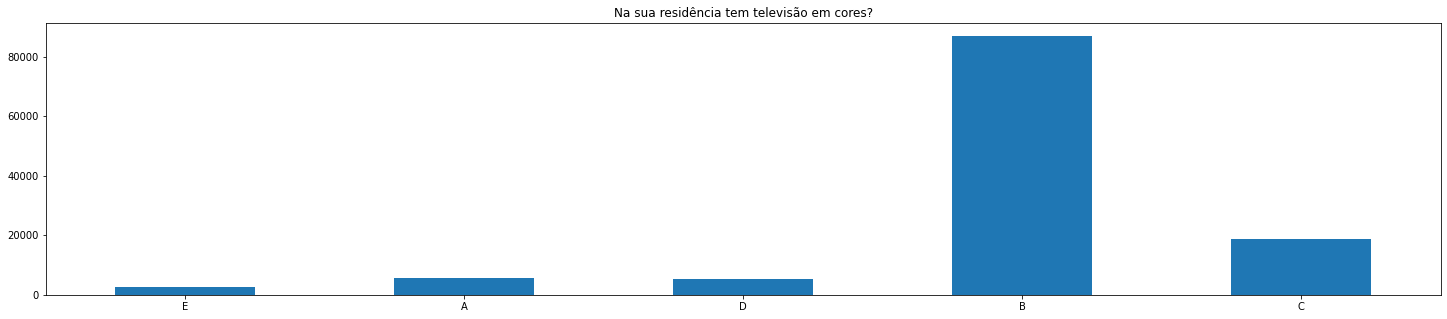

In [44]:
'''
A	Não.
B	Sim, uma.
C	Sim, duas.
D	Sim, três.
E	Sim, quatro ou mais.
'''

enem_original_df['Q019'].value_counts(sort=False).plot(title='Na sua residência tem televisão em cores?', kind='bar', figsize=(25,5), rot=0)

#### Dados do questionário socioeconômico [Q020]

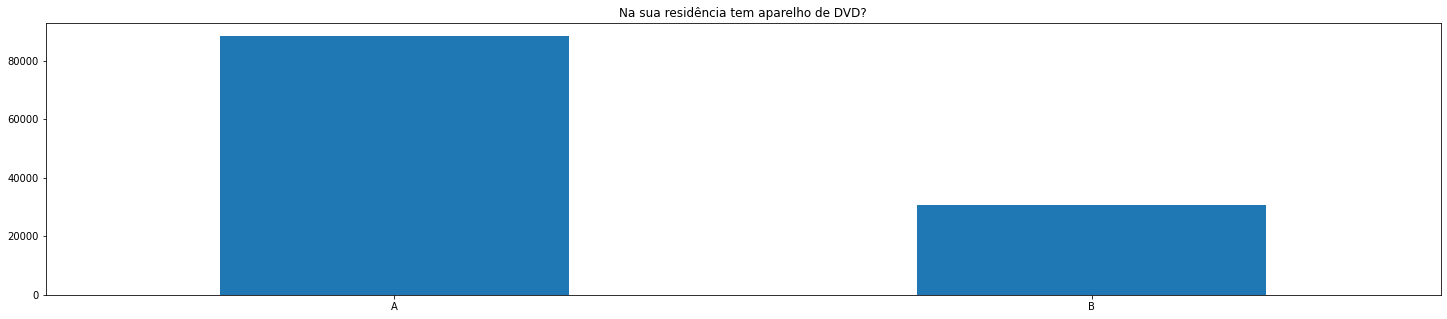

In [45]:
'''
A	Não.
B	Sim.
'''

enem_original_df['Q020'].value_counts(sort=False).plot(title='Na sua residência tem aparelho de DVD?', kind='bar', figsize=(25,5), rot=0)

#### Dados do questionário socioeconômico [Q021]

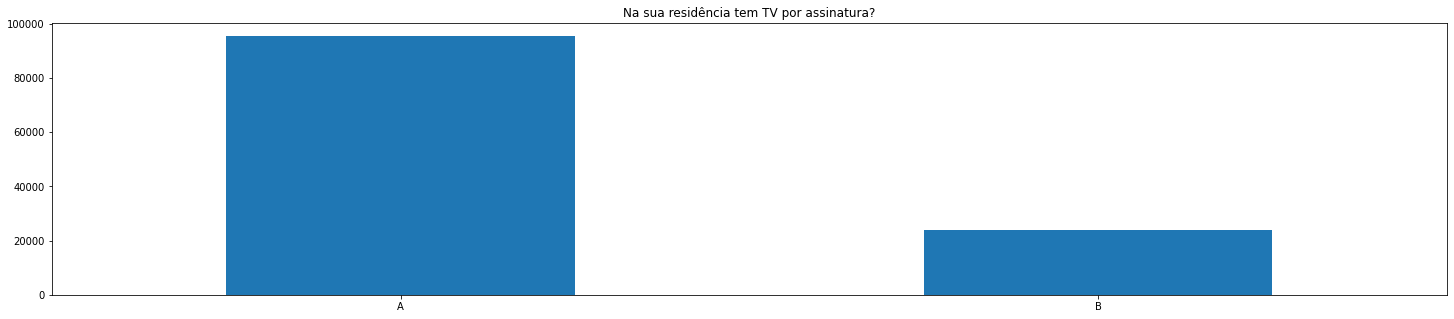

In [46]:
'''
A	Não.
B	Sim.
'''

enem_original_df['Q021'].value_counts(sort=False).plot(title='Na sua residência tem TV por assinatura?', kind='bar', figsize=(25,5), rot=0)

#### Dados do questionário socioeconômico [Q022]

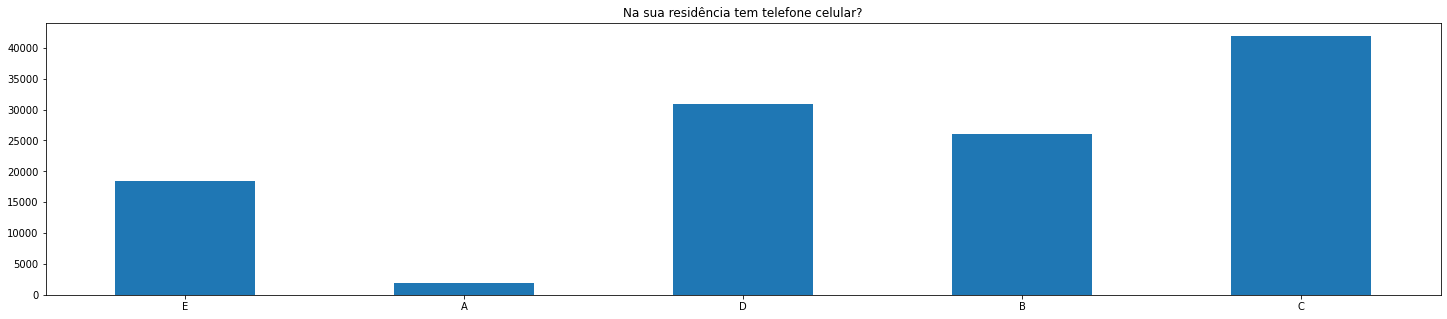

In [47]:
'''
A	Não.
B	Sim, um.
C	Sim, dois.
D	Sim, três.
E	Sim, quatro ou mais.
'''

enem_original_df['Q022'].value_counts(sort=False).plot(title='Na sua residência tem telefone celular?', kind='bar', figsize=(25,5), rot=0)

#### Dados do questionário socioeconômico [Q023]

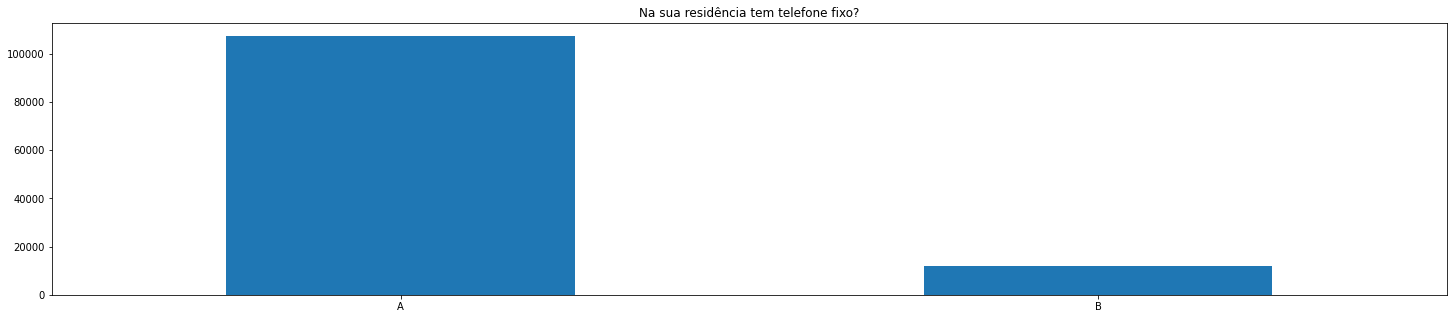

In [48]:
'''
A	Não.
B	Sim.
'''

enem_original_df['Q023'].value_counts(sort=False).plot(title='Na sua residência tem telefone fixo?', kind='bar', figsize=(25,5), rot=0)

#### Dados do questionário socioeconômico [Q024]

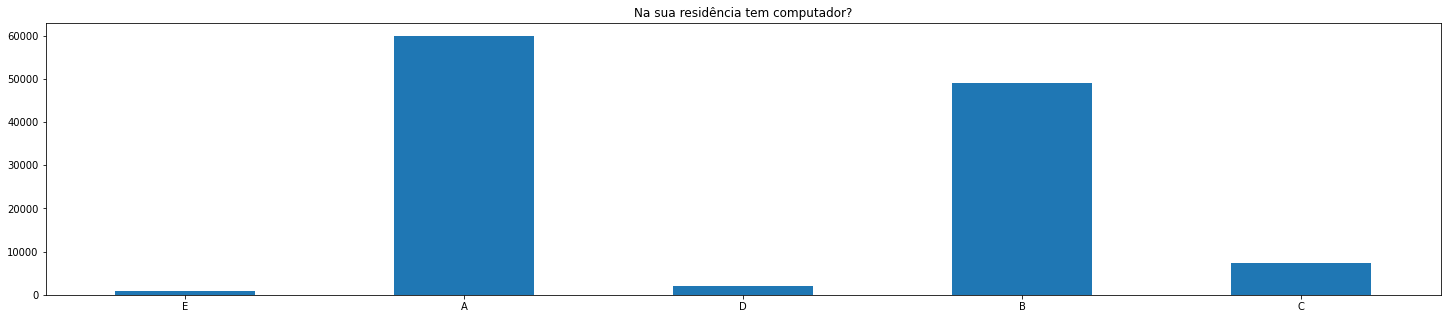

In [49]:
'''
A	Não.
B	Sim, um.
C	Sim, dois.
D	Sim, três.
E	Sim, quatro ou mais.
'''

enem_original_df['Q024'].value_counts(sort=False).plot(title='Na sua residência tem computador?', kind='bar', figsize=(25,5), rot=0)

#### Dados do questionário socioeconômico [Q025]

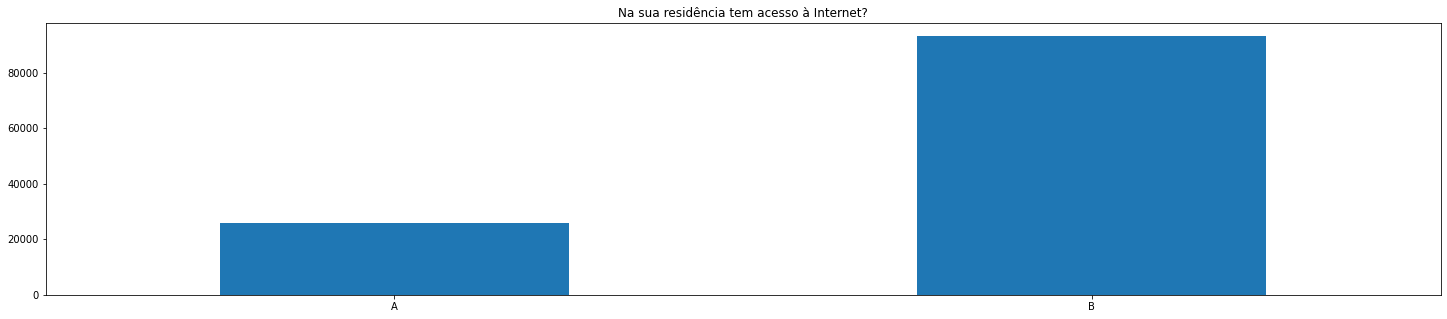

In [50]:
'''
A	Não.
B	Sim.
'''

enem_original_df['Q025'].value_counts(sort=False).plot(title='Na sua residência tem acesso à Internet?', kind='bar', figsize=(25,5), rot=0)

# 2. Aplique o pré-processamento necessário no sentido de avaliar a situação da base, em relação a dimensionalidade, dados ausentes, dados com ruídos, categorização, balanceamento, discretização, etc;

In [51]:
colunas_selecionadas = [
    'NU_INSCRICAO', 'NU_IDADE', 'TP_SEXO', 'TP_COR_RACA', 'TP_ST_CONCLUSAO', 'TP_ESCOLA', 'SG_UF_RESIDENCIA',
    'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT', 'TP_STATUS_REDACAO', 
    'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO', 
    'Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006', 'Q007','Q008','Q009', 'Q010',
    'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019', 'Q020',
    'Q021', 'Q022', 'Q023', 'Q024', 'Q025',
]

colunas_selecionadas_descricao = {
    'NU_INSCRICAO': 'Número de inscrição',
    'NU_IDADE': 'Idade',
    'TP_SEXO': 'Sexo',
    'TP_COR_RACA': 'Cor/Raça',
    'TP_ST_CONCLUSAO': 'Situação de conclusão do Ensino Médio',
    'TP_ESCOLA': 'Tipo de escola do Ensino Médio',    
    'TP_PRESENCA_CN': 'Presença na prova objetiva de Ciências da Natureza',
    'TP_PRESENCA_CH': 'Presença na prova objetiva de Ciências Humanas',
    'TP_PRESENCA_LC': 'Presença na prova objetiva de Linguagens e Códigos',
    'TP_PRESENCA_MT': 'Presença na prova objetiva de Matemática',
    'TP_STATUS_REDACAO': 'Situação da redação do participante',
    'NU_NOTA_CN': 'Nota da prova de Ciências da Natureza',
    'NU_NOTA_CH': 'Nota da prova de Ciências Humanas',
    'NU_NOTA_LC': 'Nota da prova de Linguagens e Códigos',
    'NU_NOTA_MT': 'Nota da prova de Matemática',
    'NU_NOTA_REDACAO': 'Nota da prova de redação', 
    'SG_UF_RESIDENCIA': 'Sigla da Unidade da Federação de residência',
    'Q001': 'Até que série seu pai, ou o homem responsável por você, estudou?',
    'Q002': 'Até que série sua mãe, ou a mulher responsável por você, estudou?',
    'Q003': 'A partir da apresentação de algumas ocupações divididas em grupos ordenados, indique o grupo que contempla a ocupação mais próxima da ocupação do seu pai ou do homem responsável por você. (Se ele não estiver trabalhando, escolha uma ocupação pensando no último trabalho dele).',
    'Q004': 'A partir da apresentação de algumas ocupações divididas em grupos ordenados, indique o grupo que contempla a ocupação mais próxima da ocupação da sua mãe ou da mulher responsável por você. (Se ela não estiver trabalhando, escolha uma ocupação pensando no último trabalho dela).',
    'Q005': 'Incluindo você, quantas pessoas moram atualmente em sua residência?',
    'Q006': 'Qual é a renda mensal de sua família? (Some a sua renda com a dos seus familiares.)',
    'Q007': 'Em sua residência trabalha empregado(a) doméstico(a)?',
    'Q008': 'Na sua residência tem banheiro?',
    'Q009': 'Na sua residência tem quartos para dormir?',
    'Q010': 'Na sua residência tem carro?',
    'Q011': 'Na sua residência tem motocicleta?',
    'Q012': 'Na sua residência tem geladeira?',
    'Q013': 'Na sua residência tem freezer (independente ou segunda porta da geladeira)?',
    'Q014': 'Na sua residência tem máquina de lavar roupa? (o tanquinho NÃO deve ser considerado)',
    'Q015': 'Na sua residência tem máquina de secar roupa (independente ou em conjunto com a máquina de lavar roupa)?',
    'Q016': 'Na sua residência tem forno micro-ondas?',
    'Q017': 'Na sua residência tem máquina de lavar louça?',
    'Q018': 'Na sua residência tem aspirador de pó?',
    'Q019': 'Na sua residência tem televisão em cores?',
    'Q020': 'Na sua residência tem aparelho de DVD?',
    'Q021': 'Na sua residência tem TV por assinatura?',
    'Q022': 'Na sua residência tem telefone celular?',
    'Q023': 'Na sua residência tem telefone fixo?',
    'Q024': 'Na sua residência tem computador?',
    'Q025': 'Na sua residência tem acesso à Internet?',
}

base_selecionada_df = enem_original_df.filter(items=colunas_selecionadas)

### Calculando as notas médias das provas objetivoas e limitando a análise de alunos das escolnas públicas e privadas

In [52]:
def pipeline_notas_enem(df):
    # calcula-se a médias as notas das provas objetivas     
    df['NOTA_MEDIA'] = (df['NU_NOTA_CN'] + df['NU_NOTA_CH'] + df['NU_NOTA_LC'] + df['NU_NOTA_MT']) / 4
    
    # Filtramos os registros de com alunos de escolas públicas e privadas (valores 2 e 3 no 
    # campo TP_ESCOLA)
    '''
    1	Não Respondeu
    2	Pública
    3	Privada
    4	Exterior
    '''
    df = df.loc[df['TP_ESCOLA'].isin([2, 3])]
    df.loc[df['TP_ESCOLA']==2, 'TP_ESCOLA'] = 'Pública'
    df.loc[df['TP_ESCOLA']==3, 'TP_ESCOLA'] = 'Privada'
#     df.loc[df['TP_ESCOLA']==2, 'TP_ESCOLA'] = 1
#     df.loc[df['TP_ESCOLA']==3, 'TP_ESCOLA'] = 0
    
    return df

### (i) Filtro de Instâncias

In [53]:
base_selecionada_df = pipeline_notas_enem(base_selecionada_df)    
base_selecionada_df[['TP_ESCOLA', 'NU_NOTA_REDACAO']].groupby('TP_ESCOLA').describe()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


NU_NOTA_REDACAO                          ...                      
                    count        mean         std  ...    50%    75%     max
TP_ESCOLA                                          ...                      
Privada            4007.0  728.125780  168.710880  ...  740.0  860.0  1000.0
Pública           19271.0  567.547091  192.290748  ...  580.0  680.0   980.0

[2 rows x 8 columns]

## Exercício 1

1º Exercício proposto na disciplina de AM

### 1. Exibir a descrição das bases (original);

In [54]:
base_selecionada_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25705 entries, 13 to 119172
Data columns (total 43 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   NU_INSCRICAO       25705 non-null  int64  
 1   NU_IDADE           25705 non-null  int64  
 2   TP_SEXO            25705 non-null  object 
 3   TP_COR_RACA        25705 non-null  int64  
 4   TP_ST_CONCLUSAO    25705 non-null  int64  
 5   TP_ESCOLA          25705 non-null  object 
 6   SG_UF_RESIDENCIA   25705 non-null  object 
 7   TP_PRESENCA_CN     25705 non-null  int64  
 8   TP_PRESENCA_CH     25705 non-null  int64  
 9   TP_PRESENCA_LC     25705 non-null  int64  
 10  TP_PRESENCA_MT     25705 non-null  int64  
 11  TP_STATUS_REDACAO  23278 non-null  float64
 12  NU_NOTA_CN         22580 non-null  float64
 13  NU_NOTA_CH         23278 non-null  float64
 14  NU_NOTA_LC         23278 non-null  float64
 15  NU_NOTA_MT         22580 non-null  float64
 16  NU_NOTA_REDACAO    2

### 2. Verificar a existência de valores nulos;

In [55]:
base_selecionada_df.isnull().sum()

NU_INSCRICAO            0
NU_IDADE                0
TP_SEXO                 0
TP_COR_RACA             0
TP_ST_CONCLUSAO         0
TP_ESCOLA               0
SG_UF_RESIDENCIA        0
TP_PRESENCA_CN          0
TP_PRESENCA_CH          0
TP_PRESENCA_LC          0
TP_PRESENCA_MT          0
TP_STATUS_REDACAO    2427
NU_NOTA_CN           3125
NU_NOTA_CH           2427
NU_NOTA_LC           2427
NU_NOTA_MT           3125
NU_NOTA_REDACAO      2427
Q001                    0
Q002                    0
Q003                    0
Q004                    0
Q005                    0
Q006                    0
Q007                    0
Q008                    0
Q009                    0
Q010                    0
Q011                    0
Q012                    0
Q013                    0
Q014                    0
Q015                    0
Q016                    0
Q017                    0
Q018                    0
Q019                    0
Q020                    0
Q021                    0
Q022        

In [56]:
colunas_descricao = [
    'NU_IDADE', 'TP_COR_RACA', 'TP_ST_CONCLUSAO', 'TP_ESCOLA',
    'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO', 'NOTA_MEDIA',
    'TP_STATUS_REDACAO',
]

base_selecionada_df[colunas_descricao].head(30)

,NU_IDADE,TP_COR_RACA,TP_ST_CONCLUSAO,TP_ESCOLA,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,NOTA_MEDIA,TP_STATUS_REDACAO
13,19,3,2,Privada,557.4,597.7,572.3,630.7,660.0,589.525,1.0
17,17,3,2,Pública,615.8,593.9,584.1,700.6,820.0,623.600,1.0
19,18,1,2,Pública,386.2,382.0,484.3,502.3,420.0,438.700,1.0
21,20,1,2,Pública,445.8,511.1,498.8,412.9,600.0,467.150,1.0
26,23,5,2,Pública,488.4,502.2,450.6,423.5,580.0,466.175,1.0
28,17,1,2,Pública,539.2,554.4,609.4,633.4,940.0,584.100,1.0
31,18,1,2,Pública,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,20,3,2,Pública,487.7,497.2,555.2,493.5,540.0,508.400,1.0
47,20,3,2,Pública,548.4,512.7,554.6,545.3,640.0,540.250,1.0
52,19,1,2,Pública,447.7,553.6,574.7,545.0,580.0,530.250,1.0


### 3. Realizar a substituição destes valores pela media de cada atributo;

No nosso caso, eliminamos as linhas em que os candidatos faltaram para a realização das provas

In [57]:
enem_com_part_ausentes_df = base_selecionada_df.copy()

'''
'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT'
0	Faltou à prova
1	Presente na prova
2	Eliminado na prova
'''

'''
'TP_STATUS_REDACAO'

1	Sem problemas
2	Anulada
3	Cópia Texto Motivador
4	Em Branco
6	Fuga ao tema
7	Não atendimento ao tipo textual
8	Texto insuficiente
9	Parte desconectada

'''

enem_part_presentes_df = enem_com_part_ausentes_df.drop(enem_com_part_ausentes_df[
    (enem_com_part_ausentes_df['TP_PRESENCA_CN'] != 1) |
    (enem_com_part_ausentes_df['TP_PRESENCA_CH'] != 1) |
    (enem_com_part_ausentes_df['TP_PRESENCA_LC'] != 1) |
    (enem_com_part_ausentes_df['TP_PRESENCA_MT'] != 1) |
    (enem_com_part_ausentes_df['TP_STATUS_REDACAO'] != 1.0)
].index)

# enem_part_presentes_df = enem_com_part_ausentes_df.dropna()

In [58]:
enem_part_presentes_df.isnull().sum()

NU_INSCRICAO         0
NU_IDADE             0
TP_SEXO              0
TP_COR_RACA          0
TP_ST_CONCLUSAO      0
TP_ESCOLA            0
SG_UF_RESIDENCIA     0
TP_PRESENCA_CN       0
TP_PRESENCA_CH       0
TP_PRESENCA_LC       0
TP_PRESENCA_MT       0
TP_STATUS_REDACAO    0
NU_NOTA_CN           0
NU_NOTA_CH           0
NU_NOTA_LC           0
NU_NOTA_MT           0
NU_NOTA_REDACAO      0
Q001                 0
Q002                 0
Q003                 0
Q004                 0
Q005                 0
Q006                 0
Q007                 0
Q008                 0
Q009                 0
Q010                 0
Q011                 0
Q012                 0
Q013                 0
Q014                 0
Q015                 0
Q016                 0
Q017                 0
Q018                 0
Q019                 0
Q020                 0
Q021                 0
Q022                 0
Q023                 0
Q024                 0
Q025                 0
NOTA_MEDIA           0
dtype: int6

### Balenceamento da base QTD Escola Privada X QTD Escola Pública


In [59]:
enem_part_presentes_df.groupby(['TP_ESCOLA'])['TP_ESCOLA'].count()

TP_ESCOLA
Privada     3923
Pública    17879
Name: TP_ESCOLA, dtype: int64

## Reduzindo a base

### (ii) Feature Selection

In [60]:
colunas_selecionadas_p_reducao = [
    'NU_INSCRICAO', 'NU_IDADE', 'TP_SEXO', 'TP_COR_RACA', 'TP_ESCOLA',
    'NOTA_MEDIA', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT',
    'NU_NOTA_REDACAO', 
    'Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006', 'Q007','Q008','Q009', 'Q010',
    'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019', 'Q020',
    'Q021', 'Q022', 'Q023', 'Q024', 'Q025',
]

enem_part_presentes_red_df = enem_part_presentes_df.filter(items=colunas_selecionadas_p_reducao)

### 4. Verificar a existência de dados duplicados e realizar a devida eliminação;

In [61]:
# elimina dados duplicados com base no número de inscrição
enem_part_presentes_red_df.duplicated(['NU_INSCRICAO'])

13        False
17        False
19        False
21        False
26        False
          ...  
119140    False
119157    False
119159    False
119166    False
119170    False
Length: 21802, dtype: bool

### 5. Exibir a quantidade de atributos e de instâncias;

In [62]:
enem_part_presentes_red_df.shape

(21802, 36)

### 6. Exibir a descrição da base (atual) e comparar os valores apresentação

In [63]:
colunas_descricao = [
    'NU_IDADE', 'TP_COR_RACA', 'TP_SEXO', 'TP_ESCOLA', 
    'NOTA_MEDIA', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT',
    'NU_NOTA_REDACAO'
]
enem_part_presentes_red_df[colunas_descricao].describe()

,NU_IDADE,TP_COR_RACA,NOTA_MEDIA,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO
count,21802.000000,21802.000000,21802.000000,21802.000000,21802.000000,21802.000000,21802.000000,21802.000000
mean,18.434410,2.197642,505.250319,476.088689,504.139978,518.282281,522.490327,623.826254
std,2.795236,1.008276,70.018526,75.452434,79.197915,63.037193,107.256622,157.622061
min,8.000000,0.000000,199.450000,0.000000,0.000000,0.000000,0.000000,60.000000
25%,17.000000,1.000000,450.562500,416.100000,446.200000,479.900000,436.200000,520.000000
50%,18.000000,3.000000,494.600000,467.800000,506.700000,522.900000,500.800000,600.000000
75%,19.000000,3.000000,553.218750,532.200000,561.700000,562.800000,597.400000,720.000000
max,68.000000,5.000000,798.300000,847.800000,769.800000,719.300000,985.000000,1000.000000


### Correlação dos atributos

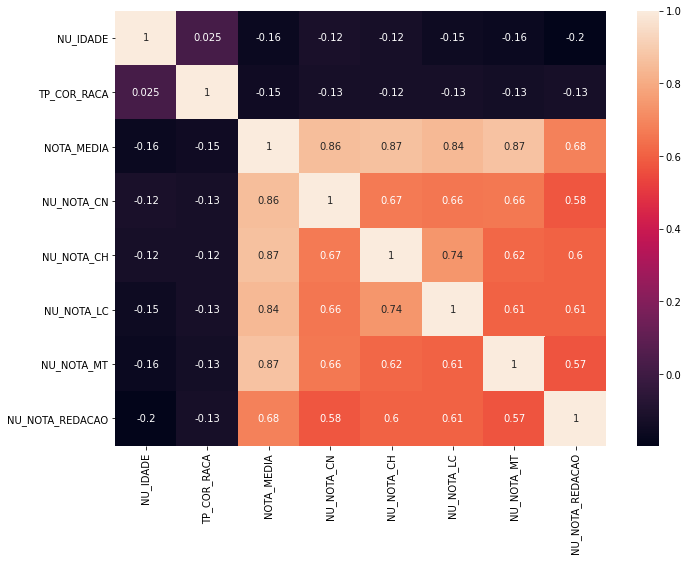

In [64]:
colunas_coor = [
    'NU_IDADE', 'TP_SEXO', 'TP_COR_RACA', 'TP_ESCOLA',
    'NOTA_MEDIA', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT',
    'NU_NOTA_REDACAO',
]
corr = enem_part_presentes_red_df[colunas_coor].corr()
ax = plt.subplots(figsize=(11, 8))
sns.heatmap(corr,  annot=True, annot_kws={"size": 10})

### Encoding de colunas categóricas

### (iii) Feature Engineering

In [65]:
ord_enc = OrdinalEncoder()

enem_part_presentes_new_base_df = enem_part_presentes_red_df.copy()

colunas_ = [
    'TP_SEXO',
    'Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006', 'Q007','Q008','Q009', 'Q010',
    'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019', 'Q020',
    'Q021', 'Q022', 'Q023', 'Q024', 'Q025',
]

enem_part_presentes_new_base_df[colunas_] = ord_enc.fit_transform(enem_part_presentes_red_df[colunas_])

enem_part_presentes_new_base_df.head(10)

,NU_INSCRICAO,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_ESCOLA,NOTA_MEDIA,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
13,190001375085,19,0.0,3,Privada,589.525,557.4,597.7,572.3,630.7,660.0,5.0,3.0,3.0,3.0,3.0,3.0,0.0,2.0,3.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0
17,190001453166,17,1.0,3,Pública,623.600,615.8,593.9,584.1,700.6,820.0,6.0,6.0,4.0,4.0,3.0,16.0,2.0,4.0,4.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,1.0,4.0,1.0,4.0,1.0
19,190001453168,18,0.0,1,Pública,438.700,386.2,382.0,484.3,502.3,420.0,3.0,4.0,0.0,0.0,2.0,2.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,1.0
21,190001453170,20,0.0,1,Pública,467.150,445.8,511.1,498.8,412.9,600.0,4.0,2.0,5.0,1.0,2.0,1.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,1.0
26,190001453175,23,0.0,5,Pública,466.175,488.4,502.2,450.6,423.5,580.0,1.0,1.0,0.0,0.0,7.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
28,190001453177,17,0.0,1,Pública,584.100,539.2,554.4,609.4,633.4,940.0,4.0,4.0,3.0,3.0,2.0,6.0,0.0,2.0,2.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,4.0,0.0,1.0,3.0,0.0,3.0,1.0
46,190001453195,20,0.0,3,Pública,508.400,487.7,497.2,555.2,493.5,540.0,1.0,2.0,2.0,2.0,5.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,1.0
47,190001453196,20,0.0,3,Pública,540.250,548.4,512.7,554.6,545.3,640.0,1.0,4.0,0.0,3.0,3.0,1.0,0.0,1.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0
52,190001453202,19,0.0,1,Pública,530.250,447.7,553.6,574.7,545.0,580.0,4.0,3.0,2.0,2.0,3.0,2.0,0.0,1.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0
55,190001453205,19,1.0,1,Pública,525.350,589.4,543.6,542.7,425.7,620.0,3.0,4.0,3.0,3.0,1.0,3.0,0.0,1.0,2.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,0.0,1.0,1.0


### Normalização dos dados

### (iv) Data Normalization

In [66]:
enem_normalized_data = enem_part_presentes_new_base_df.copy()

std_features = [
    'NOTA_MEDIA', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT',
    'NU_NOTA_REDACAO',
]

std = StandardScaler()
enem_normalized_data[std_features] = std.fit_transform(enem_part_presentes_new_base_df[std_features])

### Visualização da correlação das *features* com os valores socioeconômicos

In [67]:
col_principais = [
    'TP_SEXO', 'NU_IDADE', 'TP_COR_RACA', 'TP_ESCOLA',
    'NOTA_MEDIA', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT',
    'NU_NOTA_REDACAO'
] 

col_socio = [
    'Q001', 'Q002', 'Q003',
    'Q004', 'Q005', 'Q006', 'Q007', 'Q008', 'Q009',
    'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015',
    'Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021',
    'Q022', 'Q023', 'Q024', 'Q025'
]

cols_corr_01 = col_principais + col_socio[:5]
cols_corr_02 = col_principais + col_socio[5:10]
cols_corr_03 = col_principais + col_socio[10:15]
cols_corr_04 = col_principais + col_socio[15:20]
cols_corr_05 = col_principais + col_socio[20:]

print(col_socio[:5])
print(col_socio[5:10])
print(col_socio[10:15])
print(col_socio[15:20])
print(col_socio[20:])

['Q001', 'Q002', 'Q003', 'Q004', 'Q005']
['Q006', 'Q007', 'Q008', 'Q009', 'Q010']
['Q011', 'Q012', 'Q013', 'Q014', 'Q015']
['Q016', 'Q017', 'Q018', 'Q019', 'Q020']
['Q021', 'Q022', 'Q023', 'Q024', 'Q025']


In [68]:
def sns_plot_heatman_by(df, cols):
    corr = df[cols].corr()
    ax = plt.subplots(figsize=(22, 13))
    sns.heatmap(corr,  annot=True, annot_kws={"size": 8})

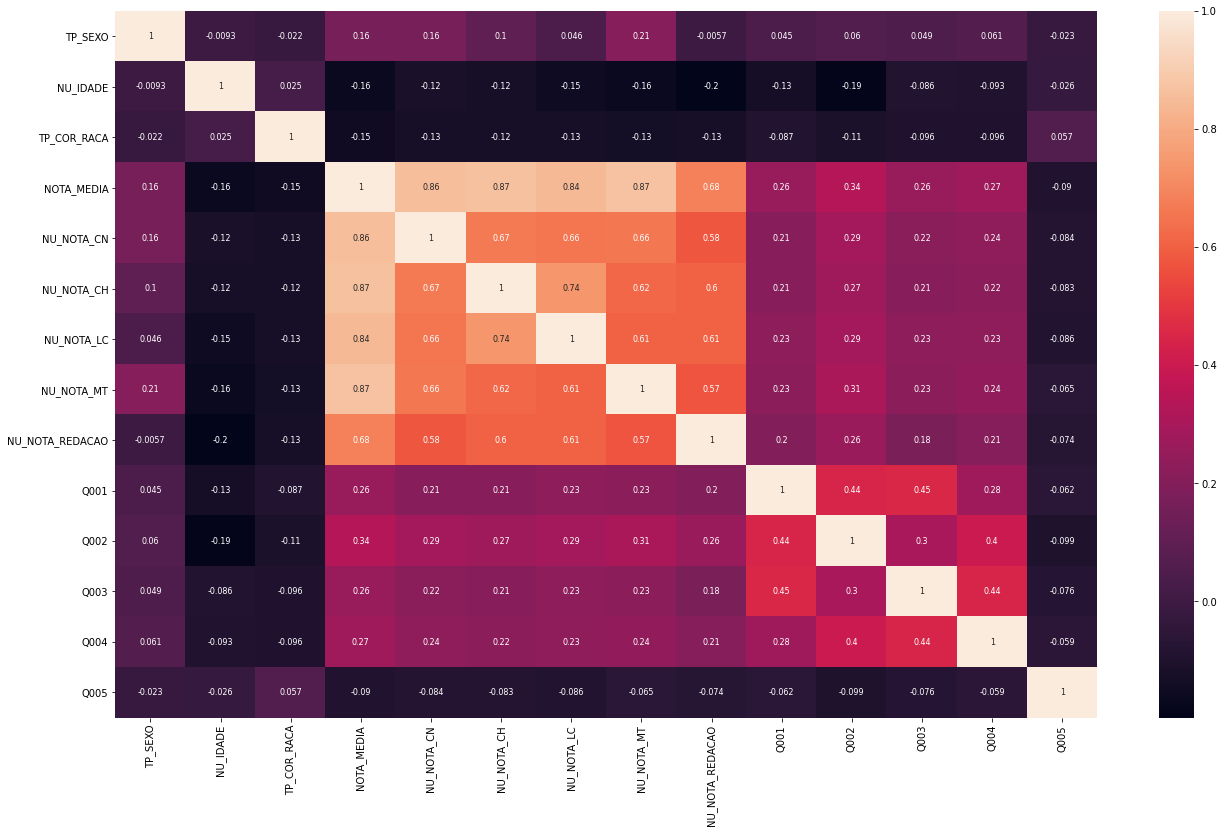

In [69]:
sns_plot_heatman_by(enem_normalized_data, cols_corr_01)

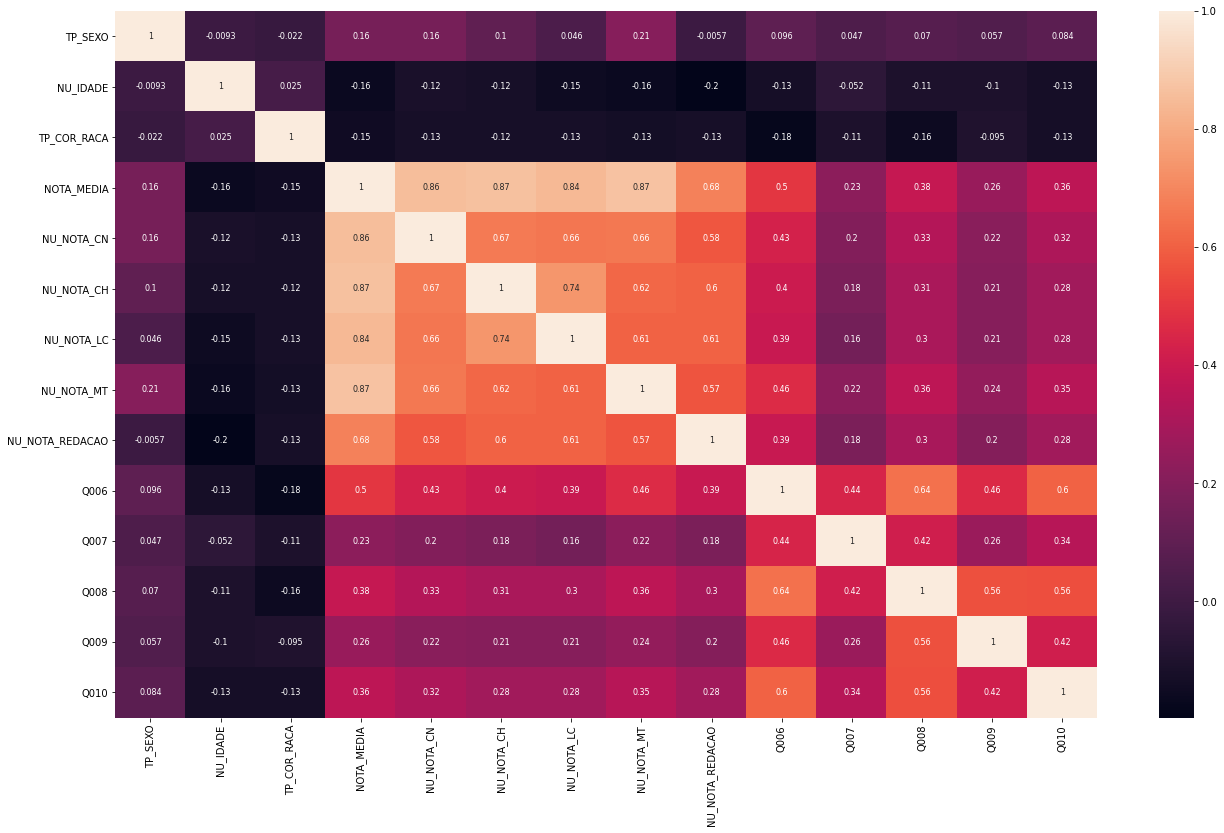

In [70]:
sns_plot_heatman_by(enem_normalized_data, cols_corr_02)

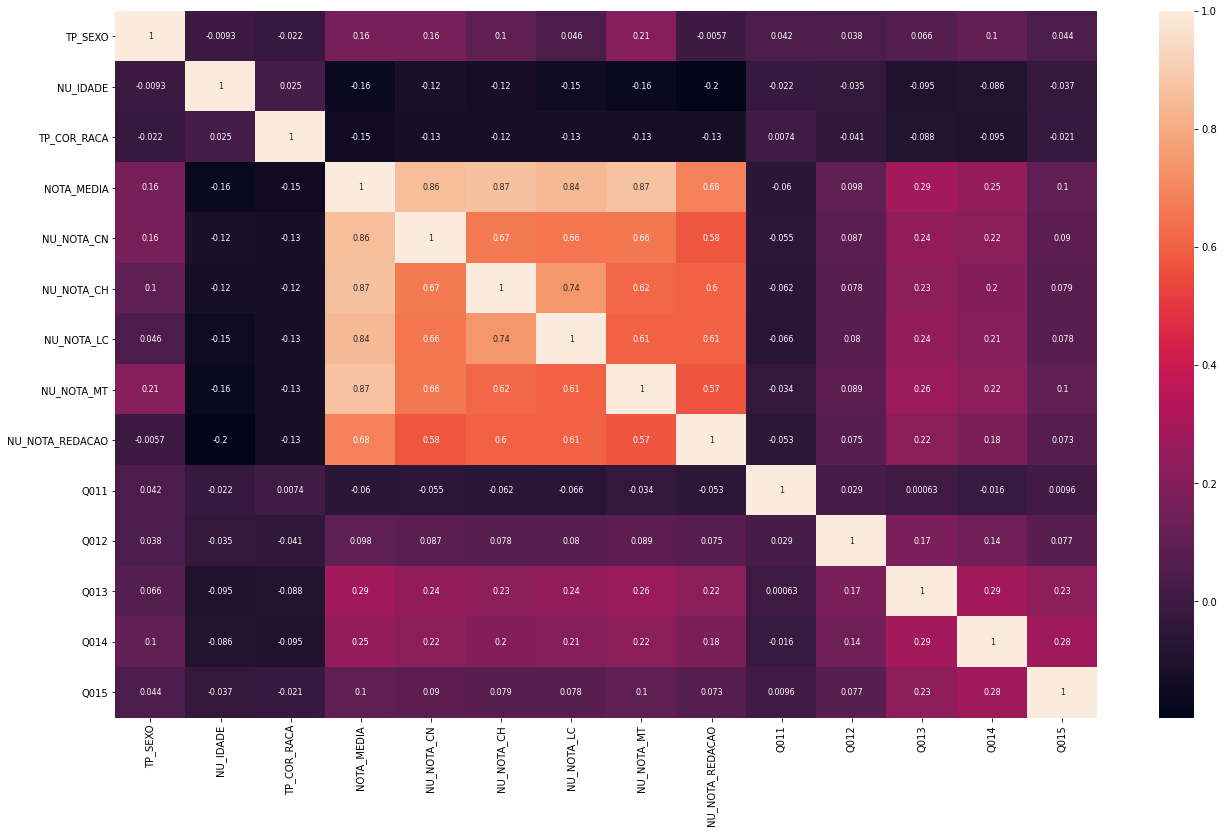

In [71]:
sns_plot_heatman_by(enem_normalized_data, cols_corr_03)

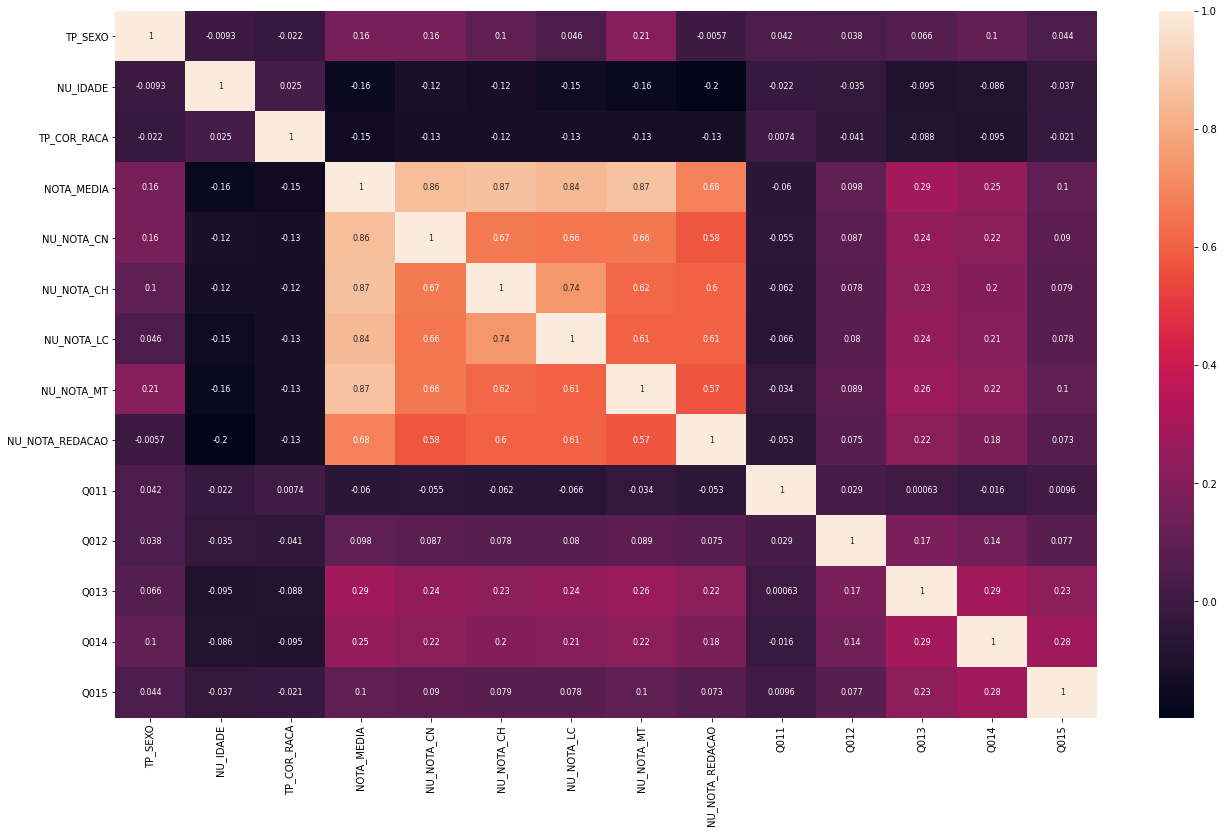

In [72]:
sns_plot_heatman_by(enem_normalized_data, cols_corr_03)

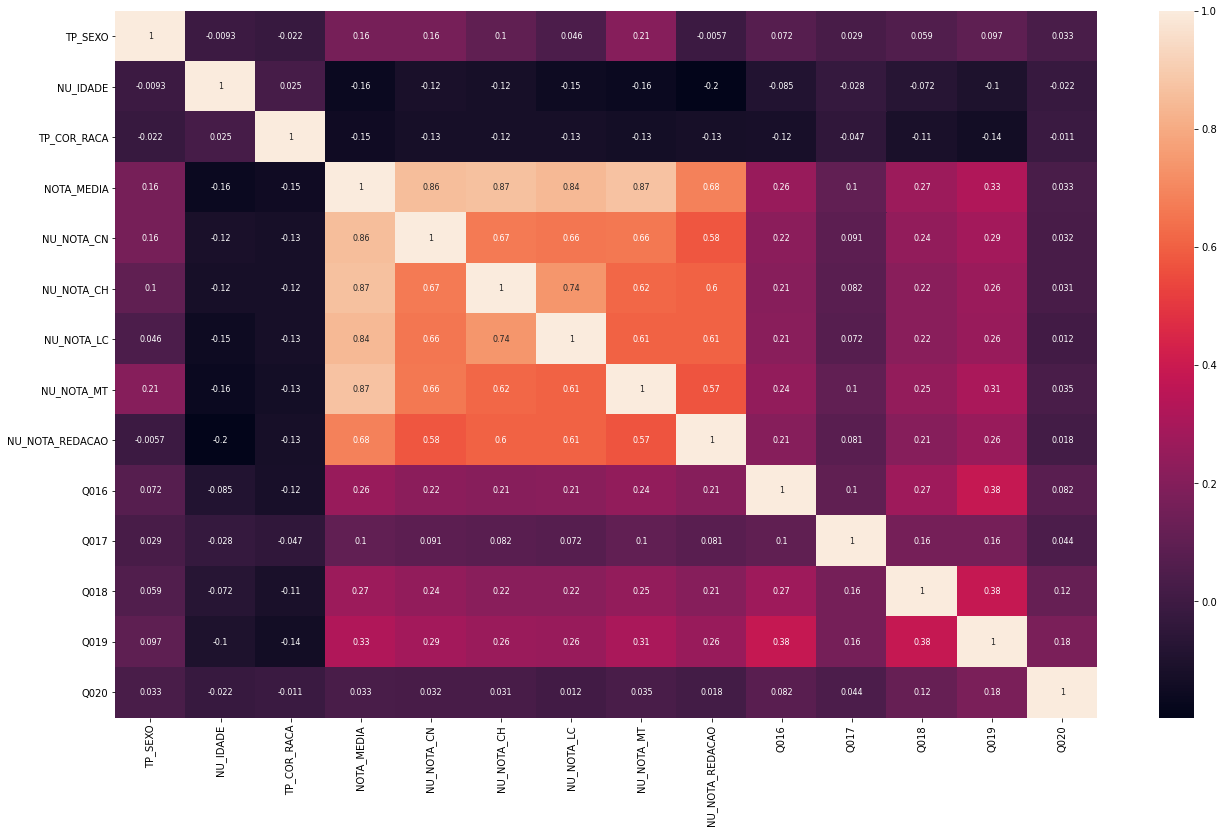

In [73]:
sns_plot_heatman_by(enem_normalized_data, cols_corr_04)

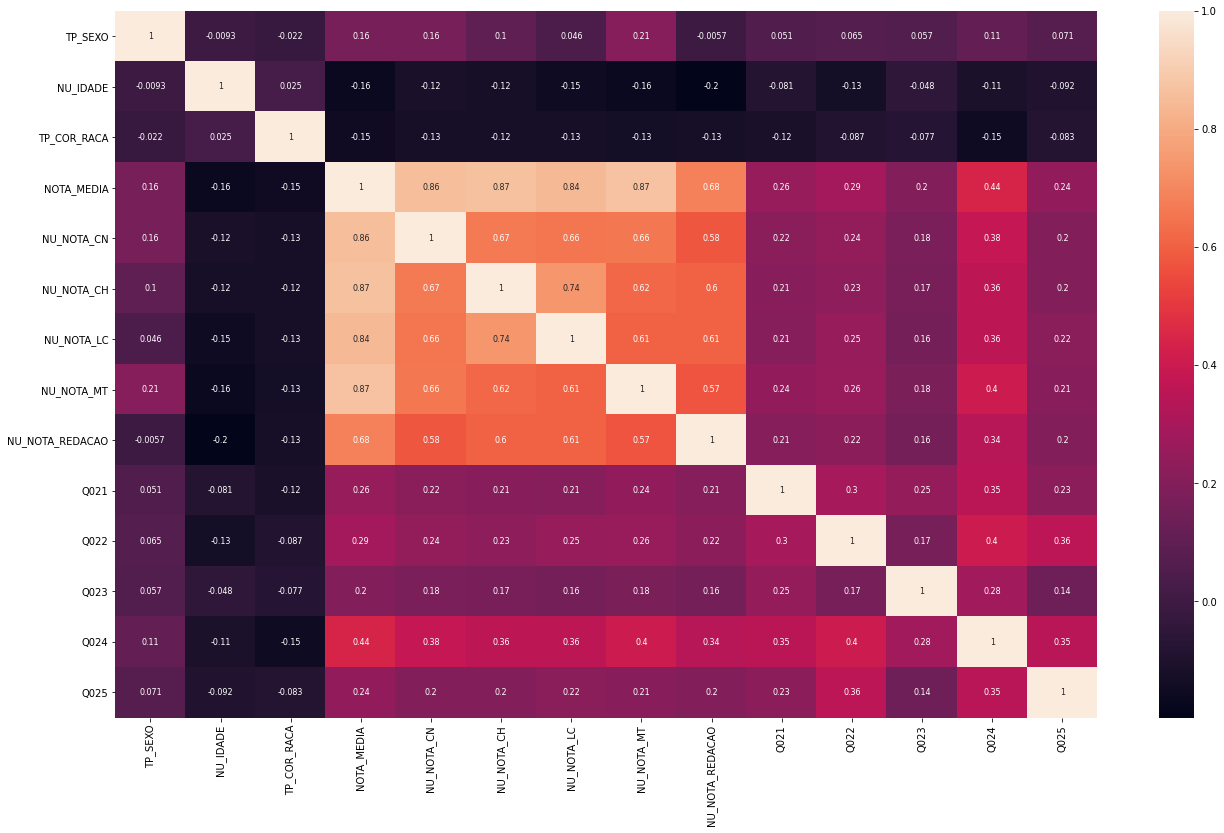

In [74]:
sns_plot_heatman_by(enem_normalized_data, cols_corr_05)

# 3. Escolher os algoritmos e a configuração dos comitês do Scikit-Learn que serão utilizados;

In [75]:
X = enem_normalized_data.drop('TP_ESCOLA', axis=1).values
y = enem_normalized_data['TP_ESCOLA'].values

enem_25percent_columns = len(enem_normalized_data.columns)//4
enem_50percent_columns = len(enem_normalized_data.columns)//2

pca_25percent = PCA(n_components=enem_25percent_columns)
principal_components_25percent = pca_25percent.fit_transform(X)
pc_df_25 = pd.DataFrame(principal_components_25percent, columns=['pc' + str(p) for p in range(enem_25percent_columns)])

pca_50percent = PCA(n_components=enem_50percent_columns)
principal_components_50percent = pca_50percent.fit_transform(X)
pc_df_50 = pd.DataFrame(principal_components_50percent, columns=['pc' + str(p) for p in range(enem_50percent_columns)])

In [76]:
print('Explained variation for 25% of principal component: {}'.format(pca_25percent.explained_variance_ratio_))

Explained variation for 25% of principal component: [1.00000000e+00 8.67871513e-12 3.96641774e-12 1.97219645e-12
 1.56655895e-12 1.08692255e-12 9.81285406e-13 9.06616095e-13
 5.80597926e-13]


In [77]:
print('Explained variation for 50% of principal component: {}'.format(pca_50percent.explained_variance_ratio_))

Explained variation for 50% of principal component: [1.00000000e+00 8.67871513e-12 3.96641774e-12 1.97219645e-12
 1.56655895e-12 1.08692256e-12 9.81285486e-13 9.06616103e-13
 5.80603276e-13 5.30936841e-13 4.96269402e-13 2.75385025e-13
 2.59256380e-13 2.28491184e-13 1.73595758e-13 1.68745744e-13
 1.60276311e-13 1.50485172e-13]


# 5. Organizar sua base em conjuntos de teste e de treinamento;

In [78]:
# Definimos uma função para treinamento e exbição dos resultados de um modelo
from sklearn.model_selection import train_test_split, cross_val_score, KFold

X = enem_normalized_data.drop('TP_ESCOLA', axis=1).values
y = enem_normalized_data['TP_ESCOLA'].values

pca_reductions = [('Original data', False), ('PCA 25% of Cols', pca_25percent), ('PCA 50% of Cols', pca_50percent)]

def pipeline_treino_teste(model):
    for i, (name, pca_method) in enumerate(pca_reductions):
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42
        )
        
        print(f'{name}')
        if pca_method:            
            ## Aplly PCA
            pca_method.fit(X_train)
            X_train = pca_method.transform(X_train)
            X_test = pca_method.transform(X_test)
        
        # Ajustamos o modelo
        model.fit(X_train, y_train)
        # Submetemos os dados de teste ao classificador 
        y_pred = model.predict(X_test)
        kfold = KFold(n_splits=10, random_state=0, shuffle=True)

        # E observamos algumas métricas de desempenho desse modelo: acurácia, F1-score e matriz de confusão
        from sklearn import metrics
        print(f'Acurácia: {metrics.accuracy_score(y_test, y_pred)}')
        print(f'F1-score médio: {metrics.f1_score(y_test, y_pred, average="weighted")}')
        print(f"F1-score da classe minoritária: {metrics.f1_score(y_test, y_pred, pos_label='Privada')}")
    #     print(f"F1-score da classe minoritária: {metrics.f1_score(y_test, y_pred)}")
        scores = cross_val_score(model, X, y, cv=kfold)    
        print("Standard deviation: {} (+/- {})".format(scores.mean(), scores.std() * 2))
        metrics.plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues, normalize='true')

# 4. Definir os parâmetros adequados para cada algoritmo;

## Classificando alunos a partir de suas notas

Utilizaremos as notas dos alunos, bem como sua classe de renda no questionário sócio-econômico, para classificar se o aluno é egresso de escola pública ou privada.

Original data
Acurácia: 0.7793915303470418
F1-score médio: 0.7452165214254657
F1-score da classe minoritária: 0.17306590257879656
Standard deviation: 0.7930461365672677 (+/- 0.01909100727978564)
PCA 25% of Cols
Acurácia: 0.7789328848799878
F1-score médio: 0.7452257338119987
F1-score da classe minoritária: 0.17465753424657535
Standard deviation: 0.7930461365672677 (+/- 0.01909100727978564)
PCA 50% of Cols
Acurácia: 0.7790857667023391
F1-score médio: 0.7450177594874368
F1-score da classe minoritária: 0.1728677733257012
Standard deviation: 0.7930461365672677 (+/- 0.01909100727978564)


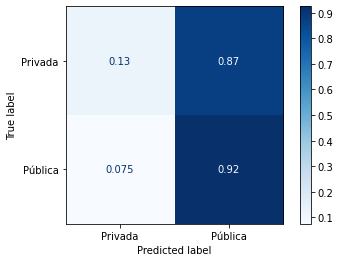

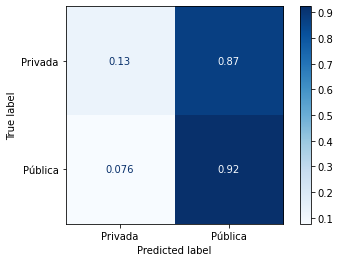

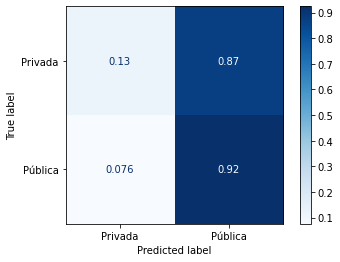

In [79]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)

pipeline_treino_teste(knn)

Original data
Acurácia: 0.8177648677572237
F1-score médio: 0.7357820483824036
F1-score da classe minoritária: 0.0
Standard deviation: 0.44032032272040855 (+/- 0.629215046910057)
PCA 25% of Cols
Acurácia: 0.5893594251643479
F1-score médio: 0.6339796233067342
F1-score da classe minoritária: 0.2814339218833601
Standard deviation: 0.44032032272040855 (+/- 0.629215046910057)
PCA 50% of Cols
Acurácia: 0.5893594251643479
F1-score médio: 0.6339796233067342
F1-score da classe minoritária: 0.2814339218833601
Standard deviation: 0.44032032272040855 (+/- 0.629215046910057)


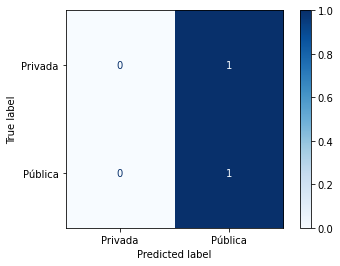

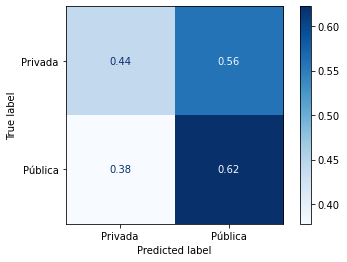

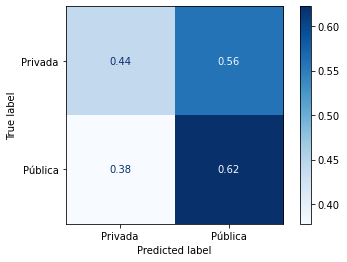

In [80]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(class_weight="balanced", loss='modified_huber', penalty="elasticnet", random_state=42)

# Executamos o pipeline de treino e teste
pipeline_treino_teste(sgd)

Original data
Acurácia: 0.18223513224277632
F1-score médio: 0.05618111409113912
F1-score da classe minoritária: 0.30828915039441357
Standard deviation: 0.17993795456170683 (+/- 0.019984470426655195)
PCA 25% of Cols
Acurácia: 0.5893594251643479
F1-score médio: 0.6339796233067342
F1-score da classe minoritária: 0.2814339218833601
Standard deviation: 0.17993795456170683 (+/- 0.019984470426655195)
PCA 50% of Cols
Acurácia: 0.5893594251643479
F1-score médio: 0.6339796233067342
F1-score da classe minoritária: 0.2814339218833601
Standard deviation: 0.17993795456170683 (+/- 0.019984470426655195)


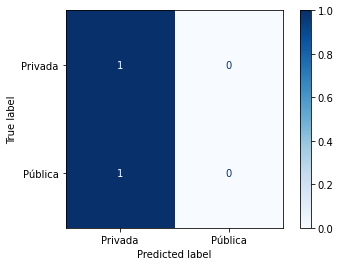

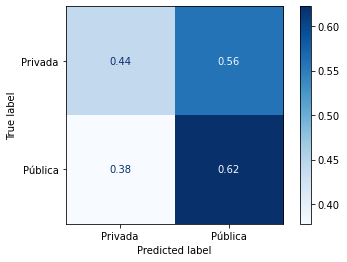

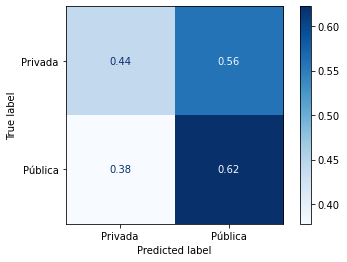

In [81]:
# Instanciamos o modelo de regressão logística
from sklearn.linear_model import LogisticRegression
rlog = LogisticRegression(class_weight="balanced")

# E submetemos ao pipeline de treino e teste
pipeline_treino_teste(rlog)

Original data
Acurácia: 0.8058400856138205
F1-score médio: 0.8211059910022684
F1-score da classe minoritária: 0.5884640311082308
Standard deviation: 0.7968069314219132 (+/- 0.01697224425820236)
PCA 25% of Cols
Acurácia: 0.807980431126739
F1-score médio: 0.823349640867448
F1-score da classe minoritária: 0.5956213779781069
Standard deviation: 0.7968069314219132 (+/- 0.01697224425820236)
PCA 50% of Cols
Acurácia: 0.807521785659685
F1-score médio: 0.8224747274332374
F1-score da classe minoritária: 0.5903026358607224
Standard deviation: 0.7968069314219132 (+/- 0.01697224425820236)


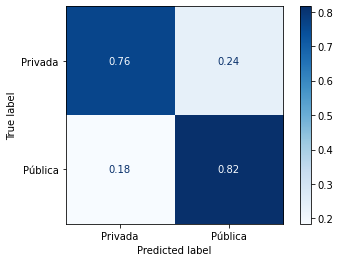

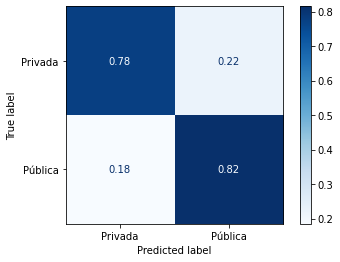

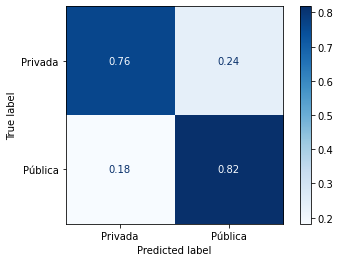

In [82]:
# Instanciamos uma árvore de decisão, com altura máxima de 3 nós
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(class_weight="balanced", max_depth=7, random_state=42)

# Executamos o pipeline de treino e teste
pipeline_treino_teste(tree)

Original data
Acurácia: 0.8798348876318606
F1-score médio: 0.8686094804558935
F1-score da classe minoritária: 0.595679012345679
Standard deviation: 0.8839095146153813 (+/- 0.011426434631882863)
PCA 25% of Cols
Acurácia: 0.8729552056260511
F1-score médio: 0.8642533455856897
F1-score da classe minoritária: 0.5928466438020578
Standard deviation: 0.8839095146153813 (+/- 0.011426434631882863)
PCA 50% of Cols
Acurácia: 0.8705090964684299
F1-score médio: 0.8592122389958788
F1-score da classe minoritária: 0.5693950177935942
Standard deviation: 0.8839095146153813 (+/- 0.011426434631882863)


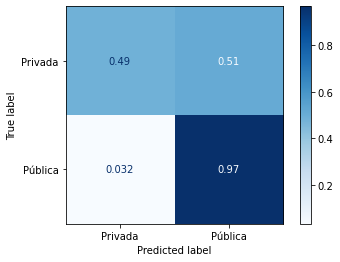

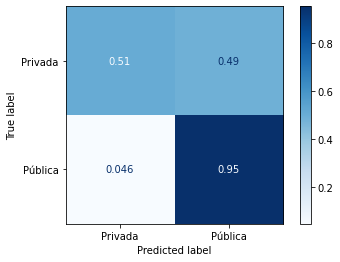

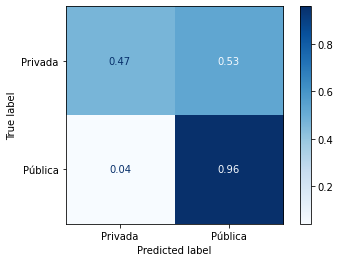

In [83]:
# Instanciamos o classificador Random Forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(class_weight="balanced", n_estimators=300, random_state=42)

# Executamos o pipeline de treino e teste
pipeline_treino_teste(rf)

Original data


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Acurácia: 0.8177648677572237
F1-score médio: 0.7357820483824036
F1-score da classe minoritária: 0.0


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

Standard deviation: 0.4950161738786602 (+/- 0.6403583970618165)
PCA 25% of Cols


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Acurácia: 0.41064057483565203
F1-score médio: 0.4652608159599245
F1-score da classe minoritária: 0.2567958357432042


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

Standard deviation: 0.4950161738786602 (+/- 0.6403583970618165)
PCA 50% of Cols


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Acurácia: 0.41064057483565203
F1-score médio: 0.4652608159599245
F1-score da classe minoritária: 0.2567958357432042


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

Standard deviation: 0.4950161738786602 (+/- 0.6403583970618165)


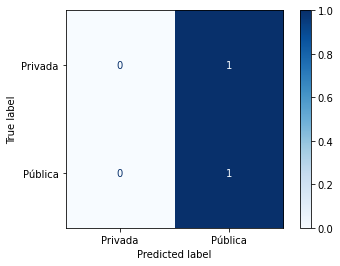

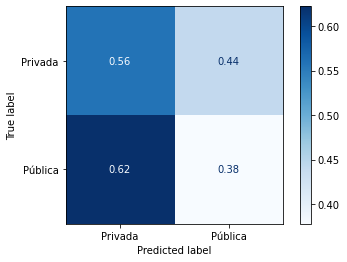

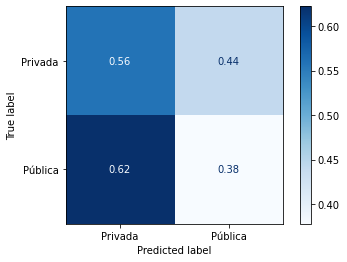

In [84]:
from sklearn.svm import LinearSVC
lsvm = LinearSVC(class_weight="balanced", max_iter=3000, random_state=42, tol=5e-4)

# Submetemos o classificador ao treino e teste
pipeline_treino_teste(lsvm)

Original data
Acurácia: 0.8804464149212659
F1-score médio: 0.8714030039553706
F1-score da classe minoritária: 0.6113320079522864
Standard deviation: 0.8862488379625539 (+/- 0.012978867539909818)
PCA 25% of Cols
Acurácia: 0.8617948325944045
F1-score médio: 0.8460511378989363
F1-score da classe minoritária: 0.5170940170940171
Standard deviation: 0.8862488379625539 (+/- 0.012978867539909818)
PCA 50% of Cols
Acurácia: 0.8726494419813484
F1-score médio: 0.8586309487334987
F1-score da classe minoritária: 0.5580901856763927
Standard deviation: 0.8862488379625539 (+/- 0.012978867539909818)


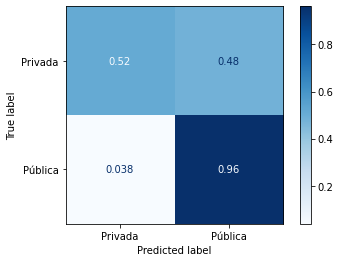

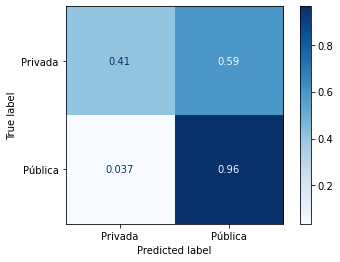

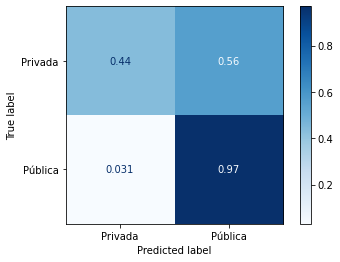

In [85]:
from xgboost import XGBClassifier
xgb = XGBClassifier(
    objective = 'multi:softmax',
    booster = 'gbtree',
    num_class = 2,
    eval_metric = 'logloss',
    eta = .1,
    max_depth = 14,
    colsample_bytree = .4,
    n_jobs=-1
)

pipeline_treino_teste(xgb)

Original data


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Acurácia: 0.8177648677572237
F1-score médio: 0.7357820483824036
F1-score da classe minoritária: 0.0


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Standard deviation: 0.7536246314080317 (+/- 0.39096856158950943)
PCA 25% of Cols


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Acurácia: 0.5222443051521174
F1-score médio: 0.5757042586025024
F1-score da classe minoritária: 0.3047830923248053


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Standard deviation: 0.7536246314080317 (+/- 0.39096856158950943)
PCA 50% of Cols


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Acurácia: 0.8350405136829231
F1-score médio: 0.7861375969815972
F1-score da classe minoritária: 0.24174279690794098


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Standard deviation: 0.7536246314080317 (+/- 0.39096856158950943)


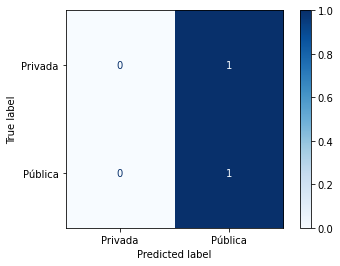

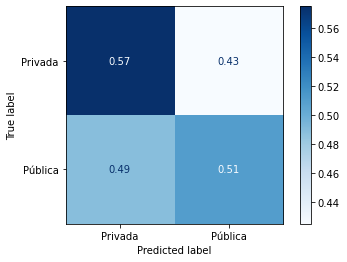

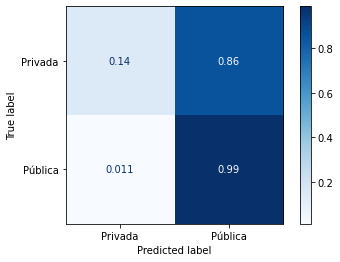

In [86]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(random_state=1, max_iter=300)

pipeline_treino_teste(mlp)

Original data
Acurácia: 0.8177648677572237
F1-score médio: 0.7357820483824036
F1-score da classe minoritária: 0.0
Standard deviation: 0.8200620454382932 (+/- 0.019984470426655177)
PCA 25% of Cols
Acurácia: 0.8177648677572237
F1-score médio: 0.7357820483824036
F1-score da classe minoritária: 0.0
Standard deviation: 0.8200620454382932 (+/- 0.019984470426655177)
PCA 50% of Cols
Acurácia: 0.8177648677572237
F1-score médio: 0.7357820483824036
F1-score da classe minoritária: 0.0
Standard deviation: 0.8200620454382932 (+/- 0.019984470426655177)


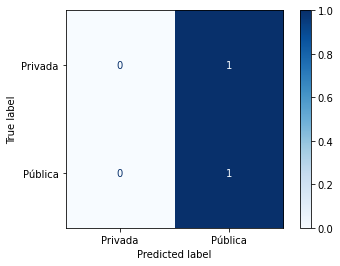

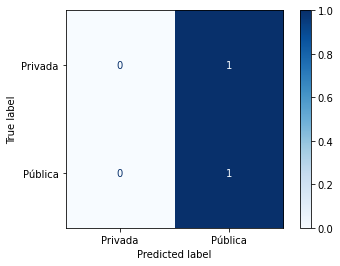

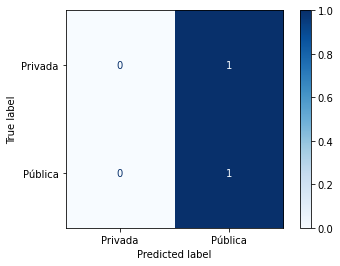

In [87]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
pipeline_treino_teste(gnb)

# 7. Aplicar os algoritmos sobre os dados (dataset) de acordo como tipo de algoritmo (supervisionado ou não) e seus respectivos métodos;

In [ ]:
## Selecionando os 5 melhores para o comite homogêneo
hmg_estimators = [
            ('rf', rf), ('xgb', xgb), ('tree', tree), ('mlp', mlp), ('gnb', gnb)
]

# 8. Aplicar os métodos de regressão (quando for o caso) e o de predição, sobre as features relacionadas aos questionamentos levantados sobre sua base (possível conhecimento).

In [ ]:
# Homogêneos
from sklearn.ensemble import BaggingClassifier

for estimator in hmg_estimators:
    for n_stimator in [1 ,3, 5]:
        print("BEGIN n_estimators: {} | Estimator: {}".format(n_stimator, estimator[0]))
        bc = BaggingClassifier(base_estimator=estimator[1], n_estimators=n_stimator, random_state=0)
        pipeline_treino_teste(bc)
        print("END n_estimators: {} | Estimator: {}".format(n_stimator, estimator[0]))

## Combinações com 2 classificadores

In [ ]:
## Selecionando os 3 melhores para o comite hetegorêneo
htg_estimators = [
            ('rf', rf), ('xgb', xgb), ('gnb', gnb)
]

In [ ]:
from sklearn.ensemble import StackingClassifier

# heterogêneos
for estimator in htg_estimators:
    for combinacao in combinations(htg_estimators, 2):
        print("BEGIN Combinação: {} | Estimator: {}".format(' + '.join([x[0] for x in combinacao]), estimator[0]))
        stack = StackingClassifier(estimators=combinacao, final_estimator=estimator[1])
        pipeline_treino_teste(stack)
        print("END Combinação: {} | Estimator: {}\n\n".format(' + '.join([x[0] for x in combinacao]), estimator[0]))

In [ ]:
from sklearn.ensemble import VotingClassifier

# Heterogêneo
for combinacao in combinations(htg_estimators, 2):
    print("BEGIN da combinação: {}".format(' + '.join([x[0] for x in combinacao])))
    vote = VotingClassifier(estimators=combinacao, voting='hard')
    pipeline_treino_teste(vote)
    print("END da combinação: {}\n\n".format(' + '.join([x[0] for x in combinacao])))

## Combinações com 3 classificadores

In [ ]:
from sklearn.ensemble import StackingClassifier

# Heterogêneo
for estimator in htg_estimators:
    for combinacao in combinations(htg_estimators, 3):
        print("BEGIN Combinação: {} | Estimator: {}".format(' + '.join([x[0] for x in combinacao]), estimator[0]))
        stack = StackingClassifier(estimators=combinacao, final_estimator=estimator[1])
        pipeline_treino_teste(stack)
        print("END Combinação: {} | Estimator: {}\n\n".format(' + '.join([x[0] for x in combinacao]), estimator[0]))

In [ ]:
from sklearn.ensemble import VotingClassifier

# Heterogêneo
for combinacao in combinations(htg_estimators, 3):
    print("BEGIN da combinação: {}".format(' + '.join([x[0] for x in combinacao])))
    vote = VotingClassifier(estimators=combinacao, voting='hard')
    pipeline_treino_teste(vote)
    print("END da combinação: {}\n\n".format(' + '.join([x[0] for x in combinacao])))

# 9. Analisar os resultados obtidos pela aplicação de cada algoritmo. As métricas de acurácia e desvio padrão, assim como as correlações existentes, deve ser enfatizadas durante a análise de resultados no artigo. Aplicar a mineração de dados descritiva e preditiva. Relatar o conhecimento extraído da base.